## Setup, Loading Data and CDFs

In [17]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'fourier'
CHANNEL = 'gray'

In [18]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_fourier_full_spaceNet.ipynb


In [19]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/fourier/gray'

In [20]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [21]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [22]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:5]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 47614,
 3: 54416,
 4: 61218,
 5: 102030,
 6: 156446,
 7: 197258,
 8: 326496,
 9: 421724,
 10: 639388,
 11: 904666,
 12: 1312786,
 13: 1904560,
 14: 2727602,
 15: 3958764,
 16: 5720482,
 17: 8298440,
 18: 11957916,
 19: 17270278,
 20: 25140192,
 21: 36322680,
 22: 52586262,
 23: 65734528,
 24: 32003410}

Running 38290 CDFs


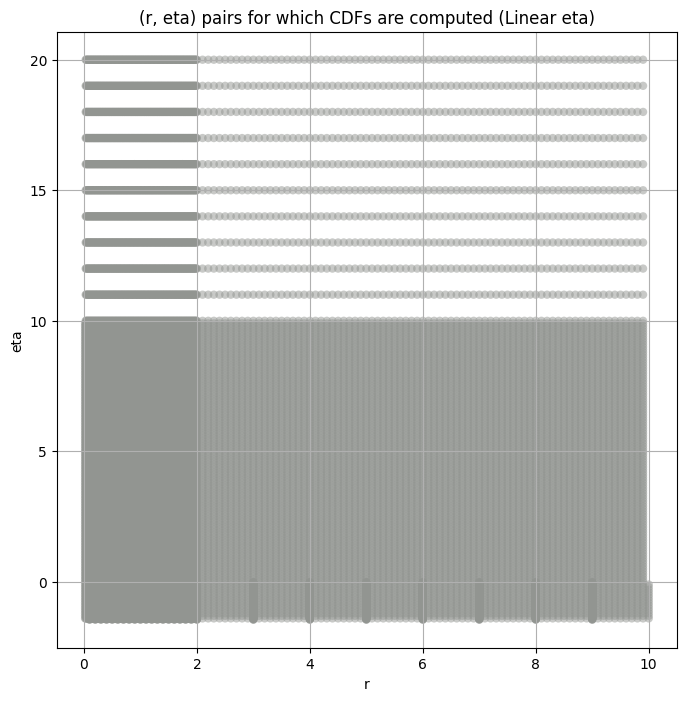

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [23]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [24]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [25]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:43<00:00, 2276.05it/s]


Band 5


100%|██████████| 100000/100000 [00:42<00:00, 2364.26it/s]


Band 8


100%|██████████| 100000/100000 [00:42<00:00, 2379.22it/s]


Band 11


100%|██████████| 100000/100000 [00:42<00:00, 2372.09it/s]


Band 14


100%|██████████| 100000/100000 [00:41<00:00, 2388.53it/s]


Band 17


100%|██████████| 100000/100000 [00:43<00:00, 2319.79it/s]


Band 20


100%|██████████| 100000/100000 [00:42<00:00, 2375.95it/s]


Band 23


100%|██████████| 100000/100000 [00:43<00:00, 2324.52it/s]


obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1317.523100  1225.378300  1416.404900    5.938153    4.311650   
5      529.166600   484.306500   580.238650   10.238717    6.227644   
8      152.612470   139.443650   167.750700   10.654584    6.318540   
11      38.099050    34.947570    41.571890    9.481829    6.036282   
14      11.219242    10.258306    12.378116   11.123092    6.303248   
17       2.759864     2.472387     3.437130   38.040096    6.955560   
20       0.457457     0.391537     0.766863  212.946980    7.135597   
23       0.108861     0.098681     0.137802   38.076750    4.879170   

      kurt_upper  total_samples  
band                             
2       8.405162        47614.0  
5      16.210070       102030.0  
8      24.114677       326496.0  
11     16.780167       904666.0  
14     29.718310      2727602.0  
17    230.069370      8298440.0  
20    983.588300     25140192.0  
23    234.754040     65734528.0

## Initial Grid Search and Hypothesis Test Plots

In [26]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [27]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr

augmented_var_df.to_csv(augmented_var_df_path)
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                               
2     1317.523100    1317.523071     1255.085327     1214.754150   
5      529.166600     529.166626      505.678558      492.727020   
8      152.612470     152.612473      145.972992      142.316696   
11      38.099050      38.099049       36.559261       35.710819   
14      11.219242      11.219242       10.746617       10.495022   
17       2.759864       2.759864        2.588251        2.521809   
20       0.457457       0.457457        0.409034        0.398037   
23       0.108861       0.108861        0.103072        0.101013   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2        1182.807739      1155.110962      1108.156738      1068.441040   
5         482.371063       473.606506       459.032501       447.012573   
8         139.420654       136.950836       132.783936       129.254883   
11         35.025200        34.429573        33.413452        32.550121   
14         10.290624        10.113163         9.809871         9.550354   
17          2.468834         2.423400         2.346224         2.280851   
20          0.389416         0.382079         0.369724         0.359329   
23          0.099319         0.097832         0.095257         0.093034   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2         1034.626953      1004.612671       977.675842       908.998352  
5          436.668304       427.246307       418.652618       396.546539  
8          126.146957       123.371338       120.845802       114.305557  
11          31.789806        31.102612        30.472372        28.829311  
14           9.321134         9.114020         8.924015         8.429741  
17           2.223387         2.171693         2.124616         2.002989  
20           0.350226         0.342062         0.334622         0.315437  
23           0.091050         0.089246         0.087584         0.083226

####
Band  2


100%|██████████| 38290/38290 [00:51<00:00, 744.25it/s]


Finding Minimum after computing 38290 CDFs
2 0 0.007651593575548676 1317.5231


100%|██████████| 38290/38290 [00:51<00:00, 740.48it/s]


Finding Minimum after computing 38290 CDFs
2 25 0.007193773842876505 1255.0853


100%|██████████| 38290/38290 [00:52<00:00, 723.92it/s]


Finding Minimum after computing 38290 CDFs
2 50 0.006836504584781633 1214.7542


100%|██████████| 38290/38290 [00:52<00:00, 733.83it/s]


Finding Minimum after computing 38290 CDFs
2 75 0.006787481249399541 1182.8077


100%|██████████| 38290/38290 [00:52<00:00, 729.71it/s]


Finding Minimum after computing 38290 CDFs
2 100 0.0065049305727851725 1155.111


100%|██████████| 38290/38290 [00:50<00:00, 757.45it/s]


Finding Minimum after computing 38290 CDFs
2 150 0.0064750253484413545 1108.1567


100%|██████████| 38290/38290 [00:50<00:00, 757.59it/s]


Finding Minimum after computing 38290 CDFs
2 200 0.006819002174164146 1068.441


100%|██████████| 38290/38290 [00:50<00:00, 756.85it/s]


Finding Minimum after computing 38290 CDFs
2 250 0.007538382765591045 1034.627
Number of samples: 47614, Without approximation : 47614.0


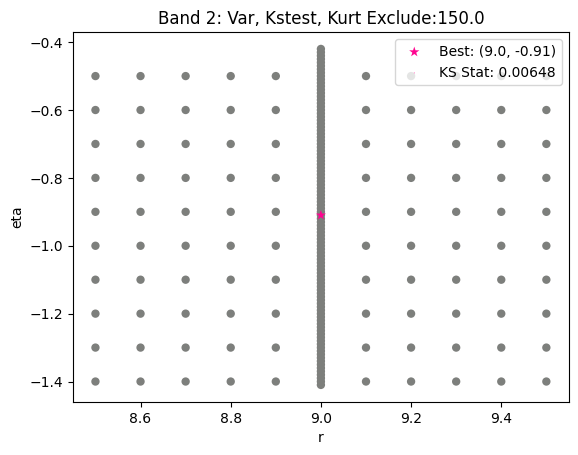

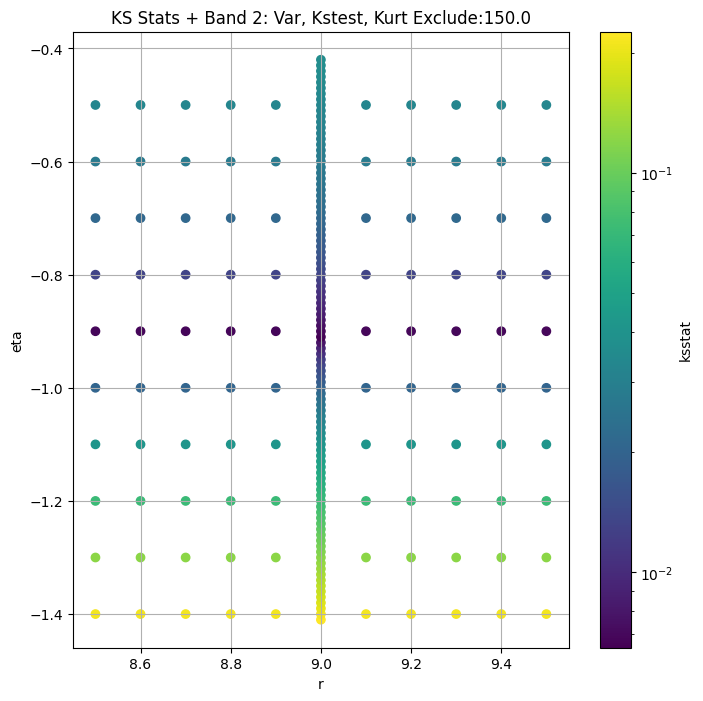

####
Band  5


100%|██████████| 38290/38290 [01:48<00:00, 351.96it/s]


Finding Minimum after computing 38290 CDFs
5 0 0.009420357234673715 529.1666


100%|██████████| 38290/38290 [01:45<00:00, 362.85it/s]


Finding Minimum after computing 38290 CDFs
5 25 0.009195712419370117 505.67856


100%|██████████| 38290/38290 [01:44<00:00, 364.86it/s]


Finding Minimum after computing 38290 CDFs
5 50 0.009021205670652233 492.72702


100%|██████████| 38290/38290 [01:44<00:00, 367.00it/s]


Finding Minimum after computing 38290 CDFs
5 75 0.008803109218183502 482.37106


100%|██████████| 38290/38290 [01:44<00:00, 366.33it/s]


Finding Minimum after computing 38290 CDFs
5 100 0.0085150351553408 473.6065


100%|██████████| 38290/38290 [01:44<00:00, 365.27it/s]


Finding Minimum after computing 38290 CDFs
5 150 0.008555527148701114 459.0325


100%|██████████| 38290/38290 [01:44<00:00, 366.56it/s]


Finding Minimum after computing 38290 CDFs
5 200 0.008339403089794861 447.01257


100%|██████████| 38290/38290 [01:44<00:00, 364.83it/s]


Finding Minimum after computing 38290 CDFs
5 250 0.008118316405090642 436.6683


100%|██████████| 38290/38290 [01:45<00:00, 362.52it/s]


Finding Minimum after computing 38290 CDFs
5 300 0.008295979667539921 427.2463
Number of samples: 100000, Without approximation : 102030.0


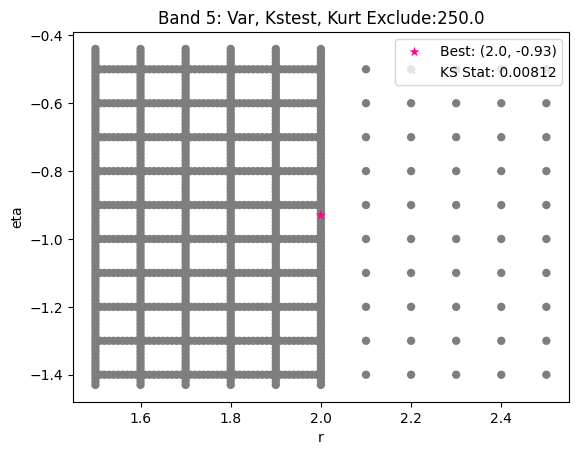

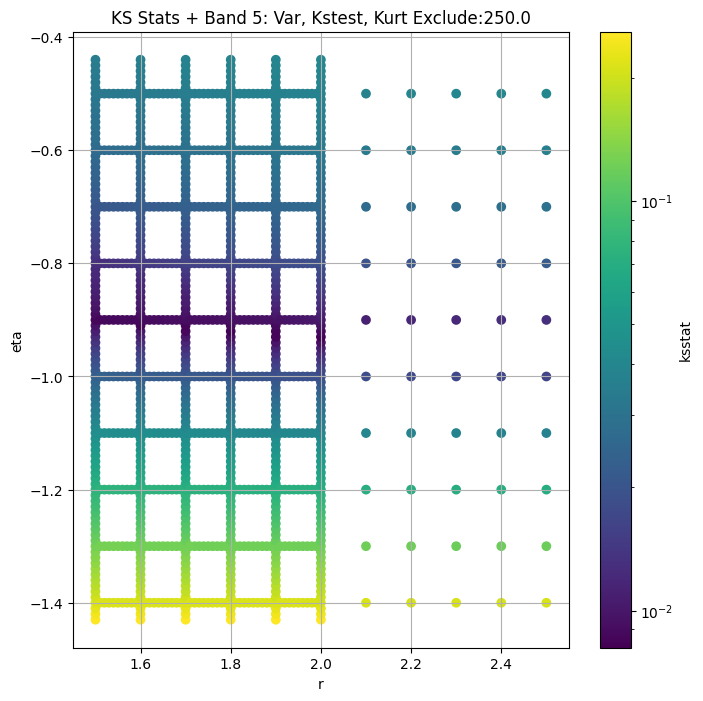

####
Band  8


100%|██████████| 38290/38290 [01:45<00:00, 364.42it/s]


Finding Minimum after computing 38290 CDFs
8 0 0.008511801204560854 152.61247


100%|██████████| 38290/38290 [01:45<00:00, 364.34it/s]


Finding Minimum after computing 38290 CDFs
8 25 0.008114868829923738 145.97299


100%|██████████| 38290/38290 [01:44<00:00, 367.11it/s]


Finding Minimum after computing 38290 CDFs
8 50 0.008069551173078726 142.3167


100%|██████████| 38290/38290 [01:44<00:00, 365.67it/s]


Finding Minimum after computing 38290 CDFs
8 75 0.007789811570061589 139.42065


100%|██████████| 38290/38290 [01:44<00:00, 366.91it/s]


Finding Minimum after computing 38290 CDFs
8 100 0.007660684914098548 136.95084


100%|██████████| 38290/38290 [01:44<00:00, 365.45it/s]


Finding Minimum after computing 38290 CDFs
8 150 0.007392340763514471 132.78394


100%|██████████| 38290/38290 [01:46<00:00, 358.31it/s]


Finding Minimum after computing 38290 CDFs
8 200 0.007385771971178512 129.25488


100%|██████████| 38290/38290 [01:44<00:00, 365.74it/s]


Finding Minimum after computing 38290 CDFs
8 250 0.007138470245397377 126.14696


100%|██████████| 38290/38290 [01:44<00:00, 365.03it/s]


Finding Minimum after computing 38290 CDFs
8 300 0.007134399201860486 123.37134


100%|██████████| 38290/38290 [01:46<00:00, 361.22it/s]


Finding Minimum after computing 38290 CDFs
8 350 0.007000090628124012 120.8458


100%|██████████| 38290/38290 [01:44<00:00, 364.79it/s]


Finding Minimum after computing 38290 CDFs
8 500 0.0076721958029172255 114.30556
Number of samples: 100000, Without approximation : 326496.0


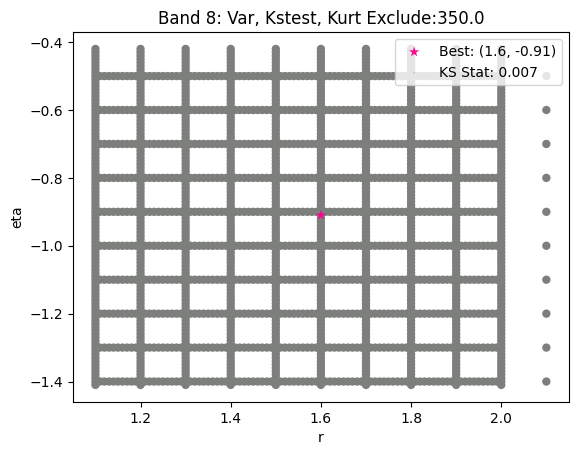

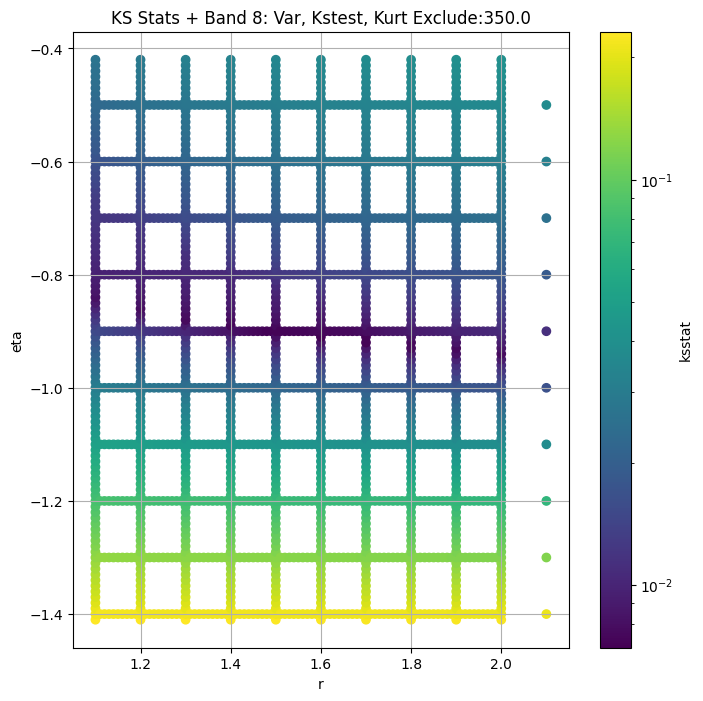

####
Band  11


100%|██████████| 38290/38290 [01:44<00:00, 367.26it/s]


Finding Minimum after computing 38290 CDFs
11 0 0.007431531014391757 38.09905


100%|██████████| 38290/38290 [01:44<00:00, 366.08it/s]


Finding Minimum after computing 38290 CDFs
11 25 0.007372171147312201 36.55926


100%|██████████| 38290/38290 [01:44<00:00, 366.05it/s]


Finding Minimum after computing 38290 CDFs
11 50 0.007411443376597604 35.71082


100%|██████████| 38290/38290 [01:48<00:00, 354.16it/s]


Finding Minimum after computing 38290 CDFs
11 75 0.007038018611638441 35.0252


100%|██████████| 38290/38290 [01:45<00:00, 363.54it/s]


Finding Minimum after computing 38290 CDFs
11 100 0.007093741845911494 34.429573
Number of samples: 100000, Without approximation : 904666.0


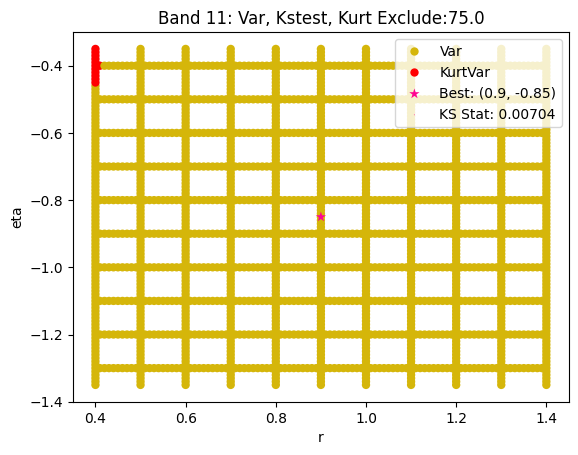

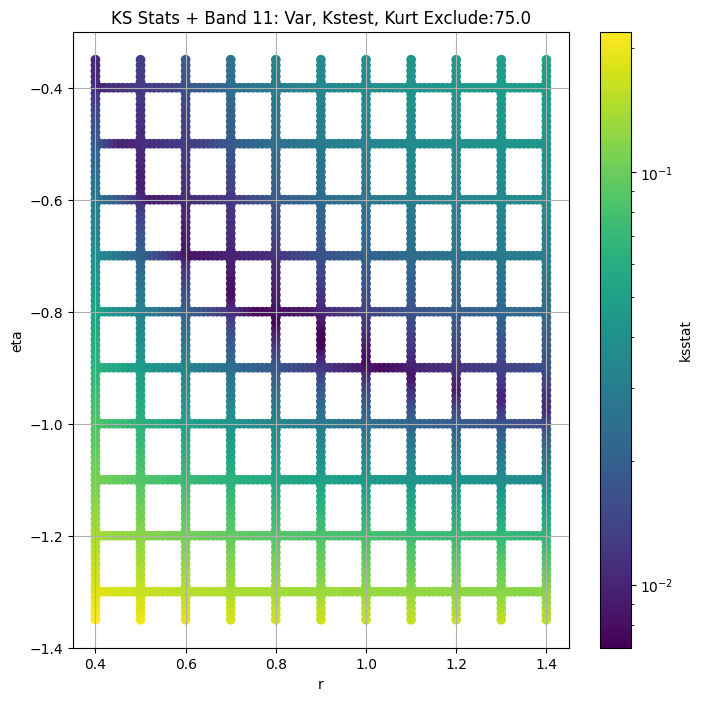

####
Band  14


100%|██████████| 38290/38290 [01:45<00:00, 362.23it/s]


Finding Minimum after computing 38290 CDFs
14 0 0.006375886268310205 11.219242


100%|██████████| 38290/38290 [01:47<00:00, 357.19it/s]


Finding Minimum after computing 38290 CDFs
14 25 0.005902003634043584 10.746617


100%|██████████| 38290/38290 [01:46<00:00, 358.73it/s]


Finding Minimum after computing 38290 CDFs
14 50 0.006083738120470805 10.495022


100%|██████████| 38290/38290 [01:45<00:00, 364.44it/s]


Finding Minimum after computing 38290 CDFs
14 75 0.005700249592520246 10.290624


100%|██████████| 38290/38290 [01:44<00:00, 367.30it/s]


Finding Minimum after computing 38290 CDFs
14 100 0.0055934345945442 10.113163


100%|██████████| 38290/38290 [01:45<00:00, 364.24it/s]


Finding Minimum after computing 38290 CDFs
14 150 0.005627990807767436 9.809871
Number of samples: 100000, Without approximation : 2727602.0


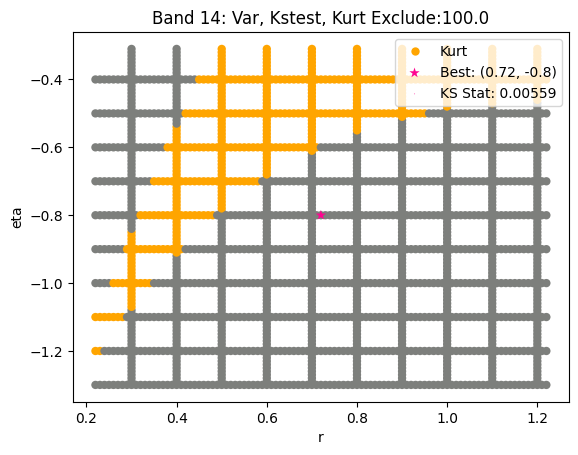

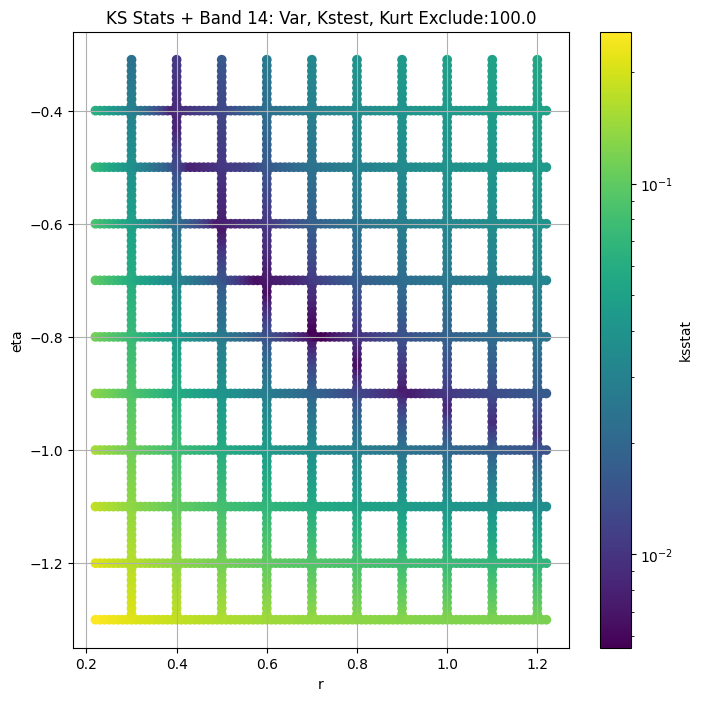

####
Band  17


100%|██████████| 38290/38290 [01:44<00:00, 365.93it/s]


Finding Minimum after computing 38290 CDFs
17 0 0.004643389752662652 2.7598639


100%|██████████| 38290/38290 [01:45<00:00, 363.36it/s]


Finding Minimum after computing 38290 CDFs
17 25 0.004275511101246132 2.5882514


100%|██████████| 38290/38290 [01:47<00:00, 354.70it/s]


Finding Minimum after computing 38290 CDFs
17 50 0.004131002704939268 2.521809


100%|██████████| 38290/38290 [01:46<00:00, 361.11it/s]


Finding Minimum after computing 38290 CDFs
17 75 0.003763489241656537 2.4688344


100%|██████████| 38290/38290 [01:45<00:00, 361.69it/s]


Finding Minimum after computing 38290 CDFs
17 100 0.0037225515665578746 2.4234004


100%|██████████| 38290/38290 [01:44<00:00, 365.06it/s]


Finding Minimum after computing 38290 CDFs
17 150 0.0037598409519740694 2.3462243


100%|██████████| 38290/38290 [01:44<00:00, 367.59it/s]


Finding Minimum after computing 38290 CDFs
17 200 0.0041825038134073456 2.2808506
Number of samples: 100000, Without approximation : 8298440.0


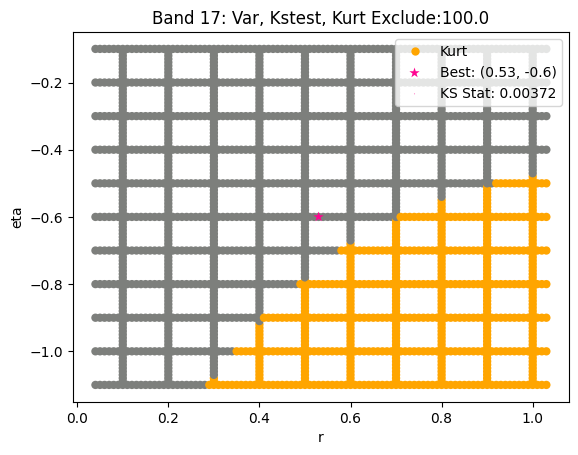

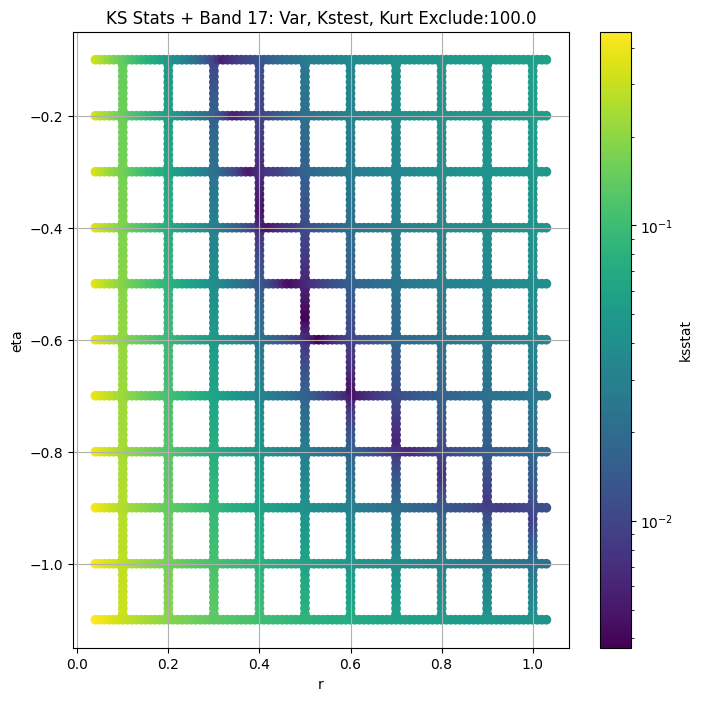

####
Band  20


100%|██████████| 38290/38290 [01:44<00:00, 367.09it/s]


Finding Minimum after computing 38290 CDFs
20 0 0.002359653268088735 0.45745653


100%|██████████| 38290/38290 [01:44<00:00, 365.85it/s]


Finding Minimum after computing 38290 CDFs
20 25 0.0017509179989042556 0.4090342


100%|██████████| 38290/38290 [01:46<00:00, 359.85it/s]


Finding Minimum after computing 38290 CDFs
20 50 0.0023270266236060655 0.3980375


100%|██████████| 38290/38290 [01:45<00:00, 362.65it/s]


Finding Minimum after computing 38290 CDFs
20 75 0.0026318600899042366 0.3894162
Number of samples: 100000, Without approximation : 25140192.0


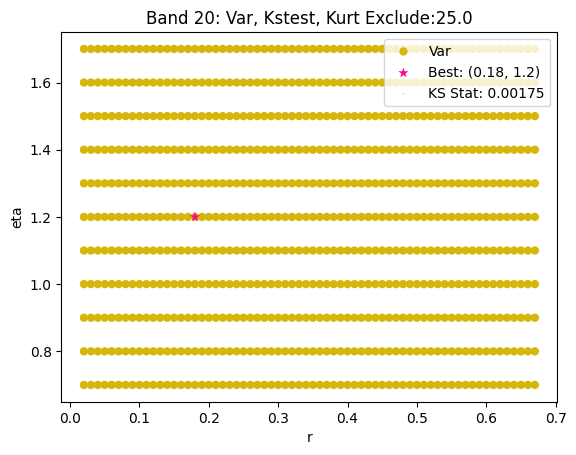

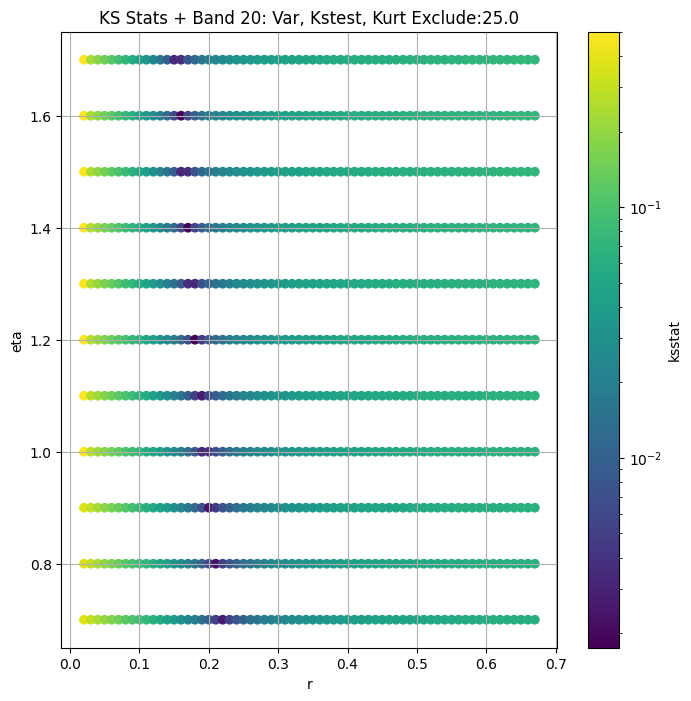

####
Band  23


100%|██████████| 38290/38290 [01:45<00:00, 363.34it/s]


Finding Minimum after computing 38290 CDFs
23 0 0.0020912464880440407 0.10886136


100%|██████████| 38290/38290 [01:44<00:00, 365.79it/s]


Finding Minimum after computing 38290 CDFs
23 25 0.0020818260290978996 0.10307153


100%|██████████| 38290/38290 [01:44<00:00, 367.00it/s]


Finding Minimum after computing 38290 CDFs
23 50 0.0024172290762151105 0.10101319


100%|██████████| 38290/38290 [01:44<00:00, 365.83it/s]


Finding Minimum after computing 38290 CDFs
23 75 0.002786660185846168 0.09931868
Number of samples: 100000, Without approximation : 65734528.0


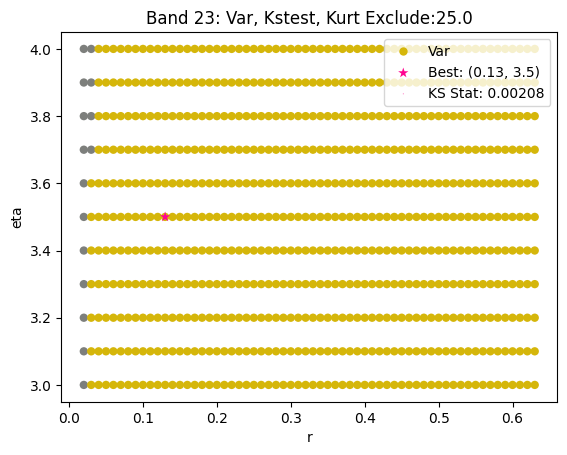

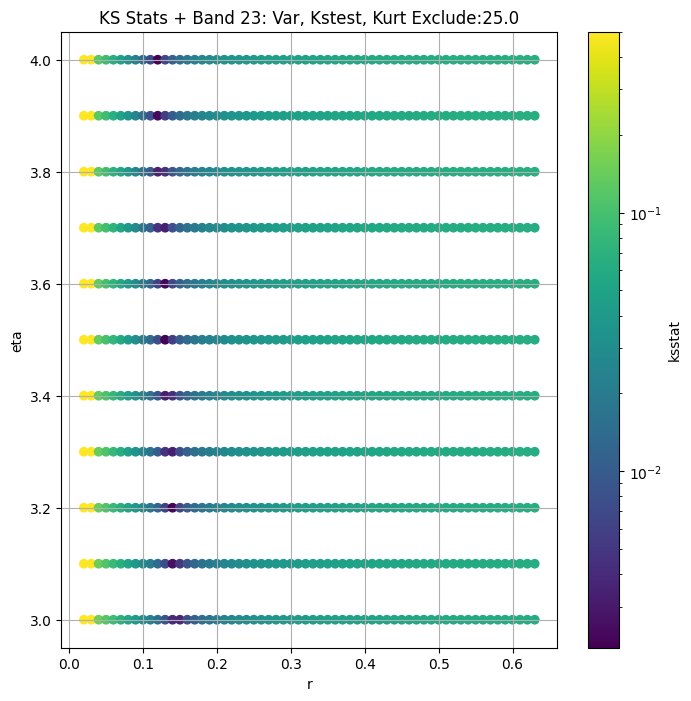

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1317.523100  1225.378300  1416.404900    5.938153    4.311650   
5      529.166600   484.306500   580.238650   10.238717    6.227644   
8      152.612470   139.443650   167.750700   10.654584    6.318540   
11      38.099050    34.947570    41.571890    9.481829    6.036282   
14      11.219242    10.258306    12.378116   11.123092    6.303248   
17       2.759864     2.472387     3.437130   38.040096    6.955560   
20       0.457457     0.391537     0.766863  212.946980    7.135597   
23       0.108861     0.098681     0.137802   38.076750    4.879170   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.405162        47614.0             0.006475       9.00        -0.91   
5      16.210070       102030.0             0.008118       2.00        -0.93   
8      24.114677       326496.0             0.007000       1.60        -0.91   
11     16.780167       904666.0             0.007038       0.90        -0.85   
14     29.718310      2727602.0             0.005593       0.72        -0.80   
17    230.069370      8298440.0             0.003723       0.53        -0.60   
20    983.588300     25140192.0             0.001751       0.18         1.20   
23    234.754040     65734528.0             0.002082       0.13         3.50   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      3.120313e+03                   150.0         1108.156700   
5      1.166934e+03                   250.0          436.668300   
8      2.904185e+02                   350.0          120.845800   
11     4.707253e+01                    75.0           35.025200   
14     8.488006e+00                   100.0           10.113163   
17     6.023926e-01                   100.0            2.423400   
20     5.584149e-08                    25.0            0.409034   
23     3.520312e-14                    25.0            0.103072   

      kstest_stat_cutoff_0.05  
band                           
2                    0.006220  
5                    0.004250  
8                    0.002376  
11                   0.001428  
14                   0.000822  
17                   0.000471  
20                   0.000271  
23                   0.000168

In [28]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1
        no_improvement_counter = 0

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]

            if no_improvement_counter > 1:
                break

            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if min_stat < master_df.loc[group, 'kstest_stat_initial']:
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
            else:
                no_improvement_counter += 1
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

In [29]:
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                               
2     1317.523100    1317.523100     1255.085300     1214.754200   
5      529.166600     529.166600      505.678560      492.727020   
8      152.612470     152.612470      145.972990      142.316700   
11      38.099050      38.099050       36.559260       35.710820   
14      11.219242      11.219242       10.746617       10.495022   
17       2.759864       2.759864        2.588251        2.521809   
20       0.457457       0.457457        0.409034        0.398037   
23       0.108861       0.108861        0.103072        0.101013   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2        1182.807700      1155.111000      1108.156700      1068.441000   
5         482.371060       473.606500       459.032500       447.012570   
8         139.420650       136.950840       132.783940       129.254880   
11         35.025200        34.429573        33.413452        32.550120   
14         10.290624        10.113163         9.809871         9.550354   
17          2.468834         2.423400         2.346224         2.280851   
20          0.389416         0.382079         0.369724         0.359329   
23          0.099319         0.097832         0.095257         0.093034   

      var_exclude_250  var_exclude_300  ...  kstest_stat_25  kstest_stat_50  \
band                                    ...                                   
2         1034.627000      1004.612700  ...        0.007194        0.006837   
5          436.668300       427.246300  ...        0.009196        0.009021   
8          126.146960       123.371340  ...        0.008115        0.008070   
11          31.789806        31.102612  ...        0.007372        0.007411   
14           9.321134         9.114020  ...        0.005902        0.006084   
17           2.223387         2.171693  ...        0.004276        0.004131   
20           0.350226         0.342062  ...        0.001751        0.002327   
23           0.091050         0.089246  ...        0.002082        0.002417   

      kstest_stat_75  kstest_stat_100  kstest_stat_150  kstest_stat_200  \
band                                                                      
2           0.006787         0.006505         0.006475         0.006819   
5           0.008803         0.008515         0.008556         0.008339   
8           0.007790         0.007661         0.007392         0.007386   
11          0.007038         0.007094              NaN              NaN   
14          0.005700         0.005593         0.005628              NaN   
17          0.003763         0.003723         0.003760         0.004183   
20          0.002632              NaN              NaN              NaN   
23          0.002787              NaN              NaN              NaN   

      kstest_stat_250  kstest_stat_300  kstest_stat_350  kstest_stat_500  
band                                                                      
2            0.007538              NaN              NaN              NaN  
5            0.008118         0.008296              NaN              NaN  
8            0.007138         0.007134            0.007         0.007672  
11                NaN              NaN              NaN              NaN  
14                NaN              NaN              NaN              NaN  
17                NaN              NaN              NaN              NaN  
20                NaN              NaN              NaN              NaN  
23                NaN              NaN              NaN              NaN  

[8 rows x 23 columns]

## Optimization

In [30]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2


100%|██████████| 420/420 [00:00<00:00, 747.43it/s]


Finding Minimum after computing 420 CDFs
2 -50 100 0.008702944493098858 1155.111 minus50


100%|██████████| 420/420 [00:00<00:00, 755.90it/s]


Finding Minimum after computing 420 CDFs
2 -40 110 0.007960018684134623 1144.9896 minus40


100%|██████████| 420/420 [00:00<00:00, 752.50it/s]


Finding Minimum after computing 420 CDFs
2 -30 120 0.007236185452866528 1135.2057 minus30


100%|██████████| 420/420 [00:00<00:00, 746.17it/s]


Finding Minimum after computing 420 CDFs
2 -20 130 0.006684691563754341 1125.8796 minus20


100%|██████████| 420/420 [00:00<00:00, 754.42it/s]


Finding Minimum after computing 420 CDFs
2 -10 140 0.0062908830339461486 1116.8701 minus10


100%|██████████| 420/420 [00:00<00:00, 749.92it/s]


Finding Minimum after computing 420 CDFs
2 0 150 0.006331673830624385 1108.1567 0


100%|██████████| 420/420 [00:00<00:00, 756.25it/s]


Finding Minimum after computing 420 CDFs
2 10 160 0.006408132327154259 1099.7069 plus10


100%|██████████| 420/420 [00:00<00:00, 755.64it/s]


Finding Minimum after computing 420 CDFs
2 20 170 0.006483303351153102 1091.5353 plus20


100%|██████████| 420/420 [00:00<00:00, 757.34it/s]


Finding Minimum after computing 420 CDFs
2 30 180 0.006527851537023566 1083.6062 plus30


100%|██████████| 420/420 [00:00<00:00, 756.72it/s]


Finding Minimum after computing 420 CDFs
2 40 190 0.0067615832014338295 1075.9092 plus40


100%|██████████| 420/420 [00:00<00:00, 756.12it/s]


Finding Minimum after computing 420 CDFs
2 50 200 0.007160274846052417 1068.441 plus50
Number of samples: 47614, Without approximation : 47614.0
Iter 1 band 2 best parameters: (8.9, -0.911, 3149.1482191620016, 140.0, 0.0062908830339461486)


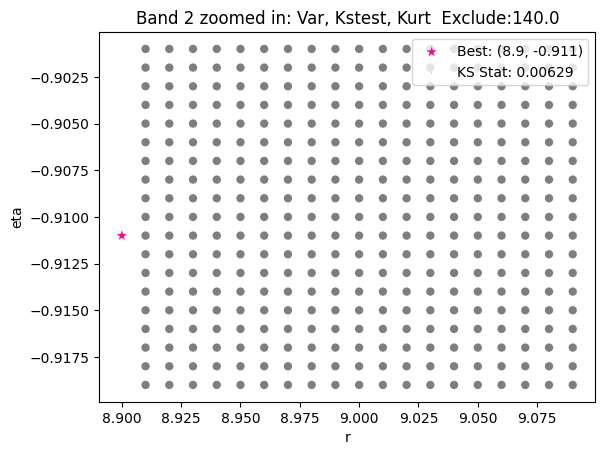

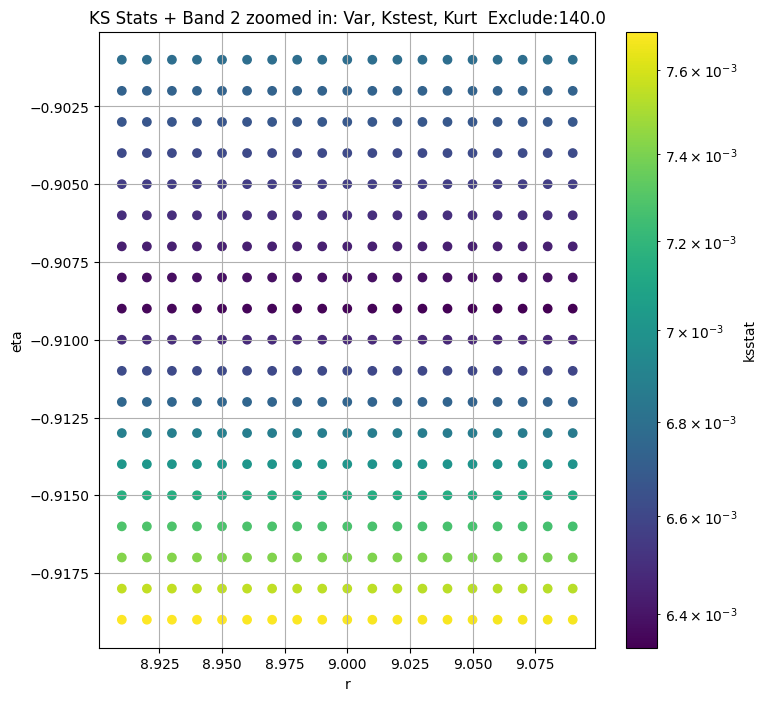

Band 5


100%|██████████| 441/441 [00:01<00:00, 364.33it/s]


Finding Minimum after computing 441 CDFs
5 -50 200 0.008666206399298493 447.01257 minus50


100%|██████████| 441/441 [00:01<00:00, 365.59it/s]


Finding Minimum after computing 441 CDFs
5 -40 210 0.00846451007172433 444.85278 minus40


100%|██████████| 441/441 [00:01<00:00, 366.89it/s]


Finding Minimum after computing 441 CDFs
5 -30 220 0.008262988343169297 442.74222 minus30


100%|██████████| 441/441 [00:01<00:00, 359.68it/s]


Finding Minimum after computing 441 CDFs
5 -20 230 0.008062348954274878 440.6747 minus20


100%|██████████| 441/441 [00:01<00:00, 366.20it/s]


Finding Minimum after computing 441 CDFs
5 -10 240 0.008056845135445467 438.65146 minus10


100%|██████████| 441/441 [00:01<00:00, 365.42it/s]


Finding Minimum after computing 441 CDFs
5 0 250 0.008034630741259874 436.6683 0


100%|██████████| 441/441 [00:01<00:00, 364.57it/s]


Finding Minimum after computing 441 CDFs
5 10 260 0.008019815277271691 434.71793 plus10


100%|██████████| 441/441 [00:01<00:00, 367.18it/s]


Finding Minimum after computing 441 CDFs
5 20 270 0.008037862062422962 432.79333 plus20


100%|██████████| 441/441 [00:01<00:00, 366.32it/s]


Finding Minimum after computing 441 CDFs
5 30 280 0.008070870121516638 430.905 plus30


100%|██████████| 441/441 [00:01<00:00, 364.84it/s]


Finding Minimum after computing 441 CDFs
5 40 290 0.00808634780375167 429.05875 plus40


100%|██████████| 441/441 [00:01<00:00, 364.56it/s]


Finding Minimum after computing 441 CDFs
5 50 300 0.00811241120424111 427.2463 plus50
Number of samples: 100000, Without approximation : 102030.0
Iter 1 band 5 best parameters: (2.07, -0.933, 1176.7758211872317, 260.0, 0.008019815277271691)


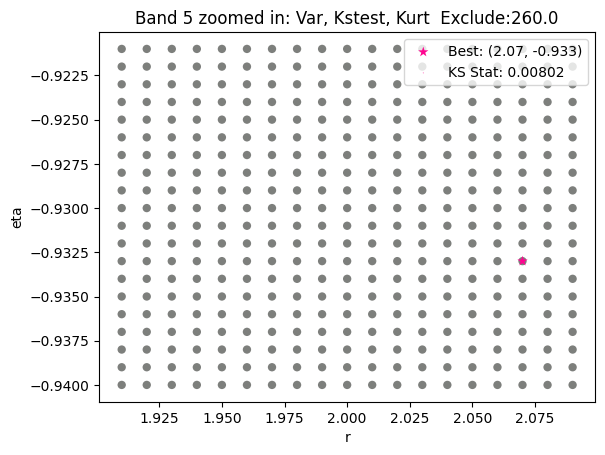

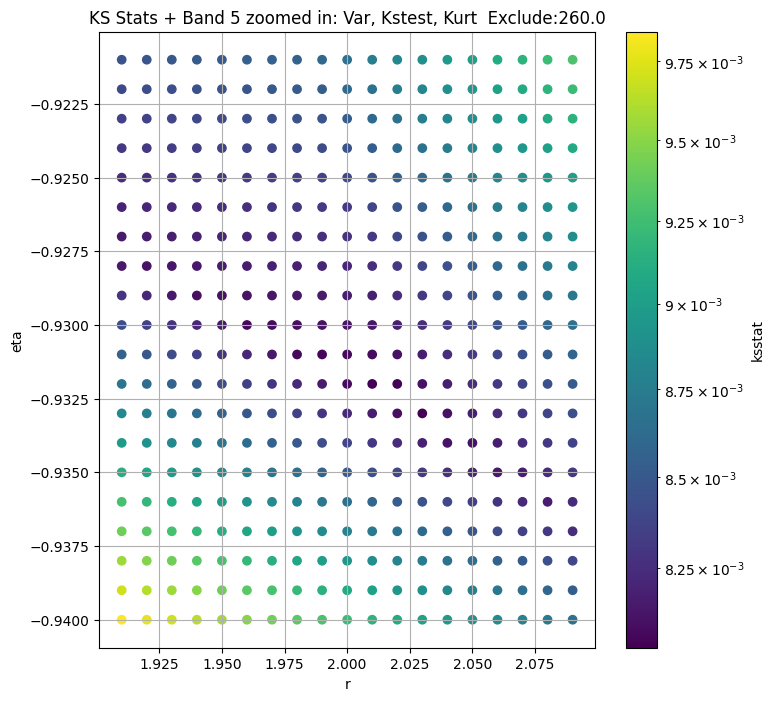

Band 8


100%|██████████| 441/441 [00:01<00:00, 362.81it/s]


Finding Minimum after computing 441 CDFs
8 -50 300 0.007171092870904228 123.37134 minus50


100%|██████████| 441/441 [00:01<00:00, 367.10it/s]


Finding Minimum after computing 441 CDFs
8 -40 310 0.006996317001126906 122.84773 minus40


100%|██████████| 441/441 [00:01<00:00, 357.81it/s]


Finding Minimum after computing 441 CDFs
8 -30 320 0.006896877404805157 122.334015 minus30


100%|██████████| 441/441 [00:01<00:00, 366.94it/s]


Finding Minimum after computing 441 CDFs
8 -20 330 0.006926911689655979 121.8297 minus20


100%|██████████| 441/441 [00:01<00:00, 365.77it/s]


Finding Minimum after computing 441 CDFs
8 -10 340 0.006949145009807034 121.33368 minus10


100%|██████████| 441/441 [00:01<00:00, 363.05it/s]


Finding Minimum after computing 441 CDFs
8 0 350 0.0069720479033990035 120.8458 0


100%|██████████| 441/441 [00:01<00:00, 366.50it/s]


Finding Minimum after computing 441 CDFs
8 10 360 0.0070141863415331684 120.364975 plus10


100%|██████████| 441/441 [00:01<00:00, 367.19it/s]


Finding Minimum after computing 441 CDFs
8 20 370 0.00703663999681492 119.89083 plus20


100%|██████████| 441/441 [00:01<00:00, 362.47it/s]


Finding Minimum after computing 441 CDFs
8 30 380 0.007058708231124533 119.42505 plus30


100%|██████████| 441/441 [00:01<00:00, 366.99it/s]


Finding Minimum after computing 441 CDFs
8 40 390 0.007089223402478251 118.9682 plus40


100%|██████████| 441/441 [00:01<00:00, 367.28it/s]


Finding Minimum after computing 441 CDFs
8 50 400 0.0071203622374634845 118.51785 plus50
Number of samples: 100000, Without approximation : 326496.0
Iter 1 band 8 best parameters: (1.608, -0.915, 296.70918631175624, 320.0, 0.006896877404805157)


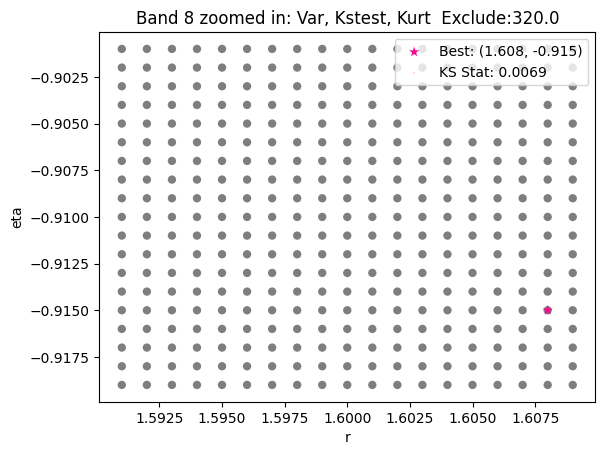

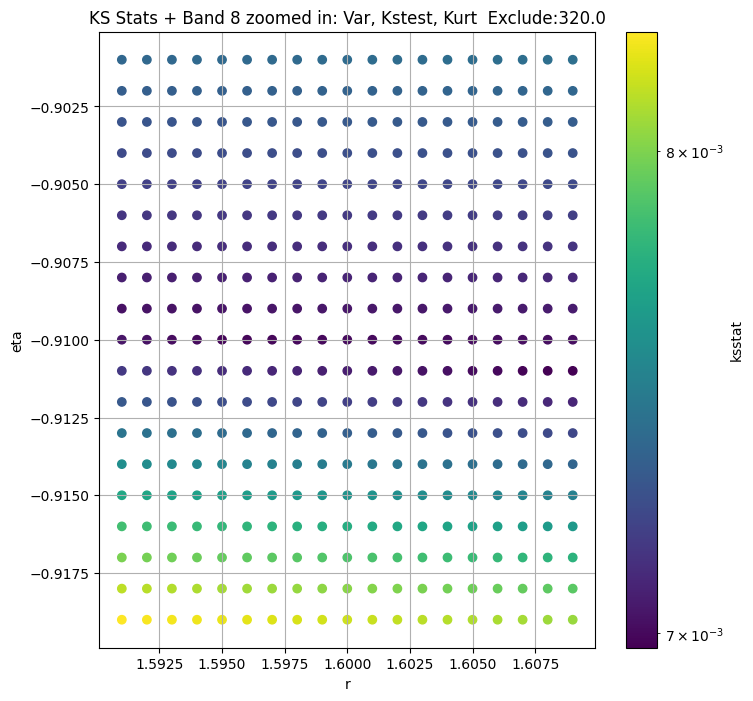

Band 11
(0.906, -0.847), 350 of 756
(0.909, -0.86), 400 of 756


100%|██████████| 441/441 [00:01<00:00, 342.57it/s]


Finding Minimum after computing 441 CDFs
11 -50 25 0.009011175146417888 36.55926 minus50


100%|██████████| 441/441 [00:01<00:00, 366.66it/s]


Finding Minimum after computing 441 CDFs
11 -40 35 0.00824675100395822 36.190742 minus40


100%|██████████| 441/441 [00:01<00:00, 365.61it/s]


Finding Minimum after computing 441 CDFs
11 -30 45 0.00756229617324275 35.863426 minus30


100%|██████████| 441/441 [00:01<00:00, 363.46it/s]


Finding Minimum after computing 441 CDFs
11 -20 55 0.006981971071796406 35.56422 minus20


100%|██████████| 441/441 [00:01<00:00, 366.97it/s]


Finding Minimum after computing 441 CDFs
11 -10 65 0.006773273715779848 35.28631 minus10


100%|██████████| 441/441 [00:01<00:00, 366.86it/s]


Finding Minimum after computing 441 CDFs
11 0 75 0.006787563909879113 35.0252 0


100%|██████████| 441/441 [00:01<00:00, 364.45it/s]


Finding Minimum after computing 441 CDFs
11 10 85 0.006837669443085059 34.77784 plus10


100%|██████████| 441/441 [00:01<00:00, 367.09it/s]


Finding Minimum after computing 441 CDFs
11 20 95 0.006878446190371257 34.542976 plus20


100%|██████████| 441/441 [00:01<00:00, 367.08it/s]


Finding Minimum after computing 441 CDFs
11 30 105 0.006928122065377851 34.318813 plus30


100%|██████████| 441/441 [00:01<00:00, 363.24it/s]


Finding Minimum after computing 441 CDFs
11 40 115 0.006971595678008424 34.103928 plus40


100%|██████████| 441/441 [00:01<00:00, 365.36it/s]


Finding Minimum after computing 441 CDFs
11 50 125 0.007022844348273272 33.897415 plus50
Number of samples: 100000, Without approximation : 904666.0
Iter 1 band 11 best parameters: (0.9, -0.858, 48.05005077288695, 65.0, 0.006773273715779848)


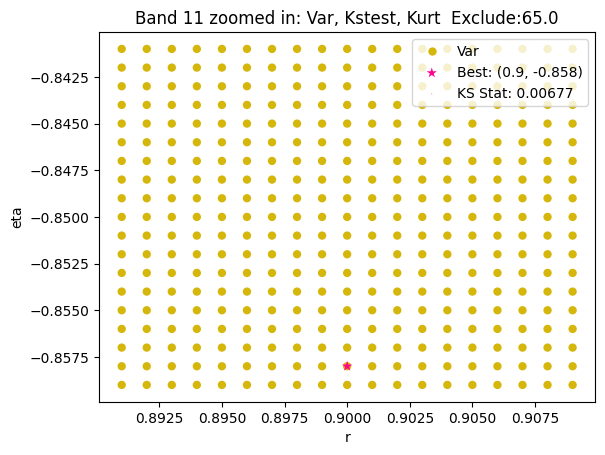

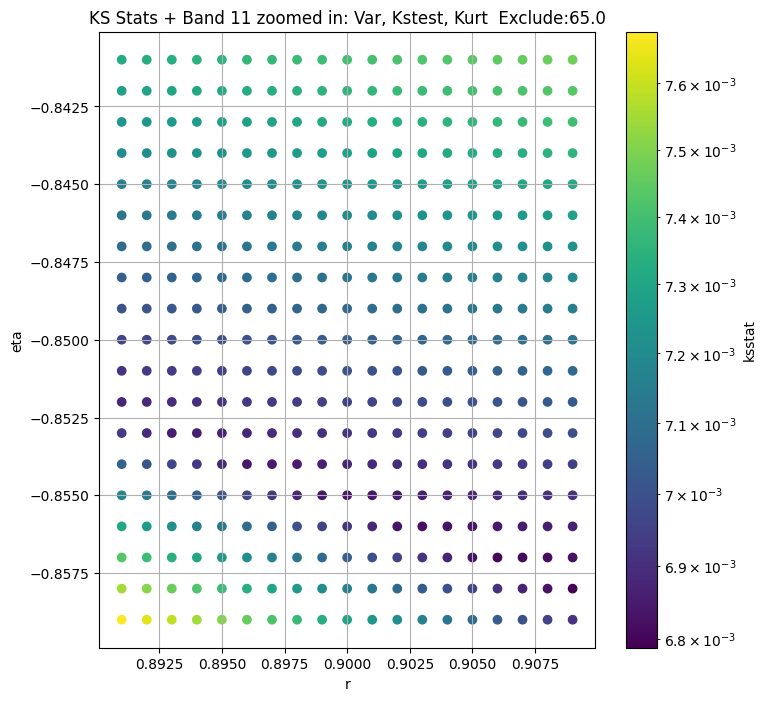

Band 14
(0.712, -0.803), 50 of 441
(0.714, -0.795), 100 of 441
(0.717, -0.808), 150 of 441
(0.719, -0.8), 200 of 441
(0.721, -0.792), 250 of 441
(0.724, -0.805), 300 of 441
(0.726, -0.797), 350 of 441
(0.729, -0.81), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 362.68it/s]


Finding Minimum after computing 441 CDFs
14 -50 50 0.0069278198777061595 10.495022 minus50


100%|██████████| 441/441 [00:01<00:00, 366.61it/s]


Finding Minimum after computing 441 CDFs
14 -40 60 0.006295422341176887 10.409141 minus40


100%|██████████| 441/441 [00:01<00:00, 332.71it/s]


Finding Minimum after computing 441 CDFs
14 -30 70 0.005817790609255802 10.328985 minus30


100%|██████████| 441/441 [00:01<00:00, 314.09it/s]


Finding Minimum after computing 441 CDFs
14 -20 80 0.005566831897799718 10.253268 minus20


100%|██████████| 441/441 [00:01<00:00, 364.25it/s]


Finding Minimum after computing 441 CDFs
14 -10 90 0.005479611625232805 10.181481 minus10


100%|██████████| 441/441 [00:01<00:00, 361.58it/s]


Finding Minimum after computing 441 CDFs
14 0 100 0.005452129257346505 10.113163 0


100%|██████████| 441/441 [00:01<00:00, 365.77it/s]


Finding Minimum after computing 441 CDFs
14 10 110 0.00549593876923038 10.047824 plus10


100%|██████████| 441/441 [00:01<00:00, 365.38it/s]


Finding Minimum after computing 441 CDFs
14 20 120 0.005539178906330822 9.98509 plus20


100%|██████████| 441/441 [00:01<00:00, 364.05it/s]


Finding Minimum after computing 441 CDFs
14 30 130 0.005590071420431109 9.924669 plus30


100%|██████████| 441/441 [00:01<00:00, 365.24it/s]


Finding Minimum after computing 441 CDFs
14 40 140 0.005618733126933728 9.866297 plus40


100%|██████████| 441/441 [00:01<00:00, 366.01it/s]


Finding Minimum after computing 441 CDFs
14 50 150 0.005662251423797948 9.809871 plus50
Number of samples: 100000, Without approximation : 2727602.0
Iter 1 band 14 best parameters: (0.73, -0.807, 8.841569369567782, 100.0, 0.005452129257346505)


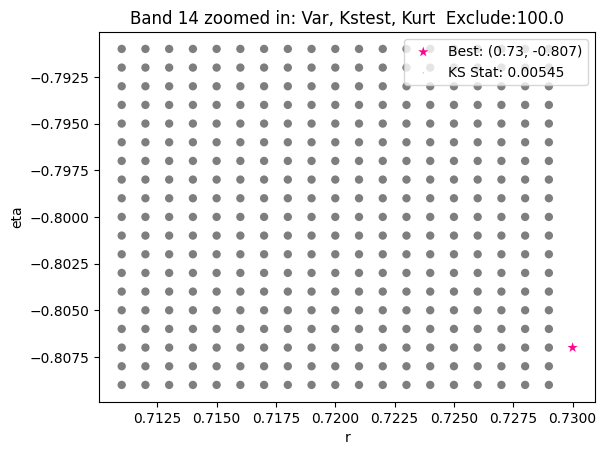

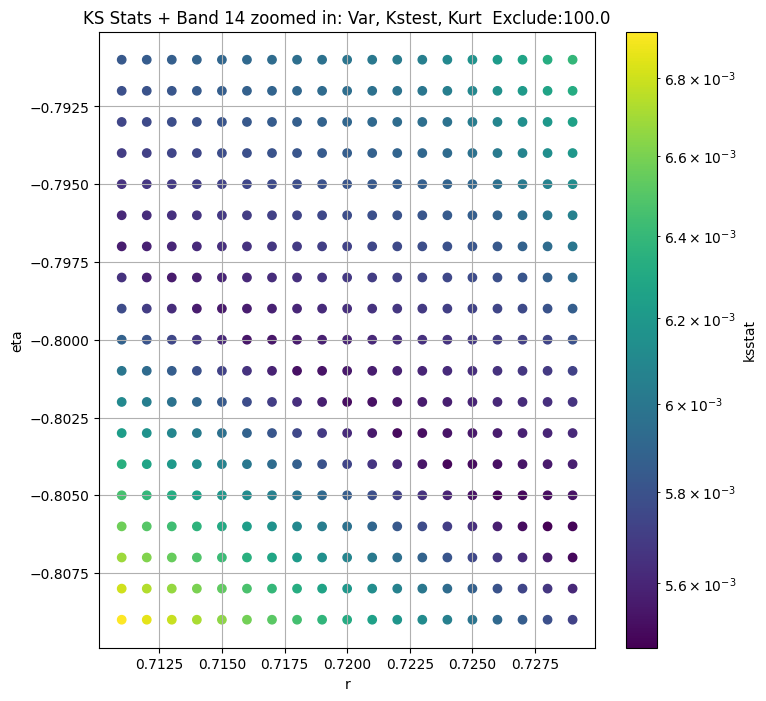

Band 17
(0.522, -0.603), 50 of 441
(0.524, -0.595), 100 of 441
(0.527, -0.608), 150 of 441
(0.529, -0.6), 200 of 441
(0.531, -0.592), 250 of 441
(0.534, -0.605), 300 of 441
(0.536, -0.597), 350 of 441
(0.539, -0.61), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 361.57it/s]


Finding Minimum after computing 441 CDFs
17 -50 50 0.005342100430646063 2.521809 minus50


100%|██████████| 441/441 [00:01<00:00, 365.42it/s]


Finding Minimum after computing 441 CDFs
17 -40 60 0.004657076201621063 2.4994688 minus40


100%|██████████| 441/441 [00:01<00:00, 365.23it/s]


Finding Minimum after computing 441 CDFs
17 -30 70 0.004154574805247502 2.4787128 minus30


100%|██████████| 441/441 [00:01<00:00, 358.26it/s]


Finding Minimum after computing 441 CDFs
17 -20 80 0.003918197230400822 2.4592488 minus20


100%|██████████| 441/441 [00:01<00:00, 362.59it/s]


Finding Minimum after computing 441 CDFs
17 -10 90 0.0036961920415390648 2.4408715 minus10


100%|██████████| 441/441 [00:01<00:00, 365.72it/s]


Finding Minimum after computing 441 CDFs
17 0 100 0.0036111085200233317 2.4234004 0


100%|██████████| 441/441 [00:01<00:00, 365.80it/s]


Finding Minimum after computing 441 CDFs
17 10 110 0.0035765485070040626 2.4067154 plus10


100%|██████████| 441/441 [00:01<00:00, 365.81it/s]


Finding Minimum after computing 441 CDFs
17 20 120 0.0036187316996294516 2.39073 plus20


100%|██████████| 441/441 [00:01<00:00, 358.80it/s]


Finding Minimum after computing 441 CDFs
17 30 130 0.0036649582628788258 2.375362 plus30


100%|██████████| 441/441 [00:01<00:00, 365.70it/s]


Finding Minimum after computing 441 CDFs
17 40 140 0.0037119312293913964 2.3605406 plus40


100%|██████████| 441/441 [00:01<00:00, 365.91it/s]


Finding Minimum after computing 441 CDFs
17 50 150 0.0037606937323291234 2.3462243 plus50
Number of samples: 100000, Without approximation : 8298440.0
Iter 1 band 17 best parameters: (0.539, -0.605, 0.6417401843525279, 110.0, 0.0035765485070040626)


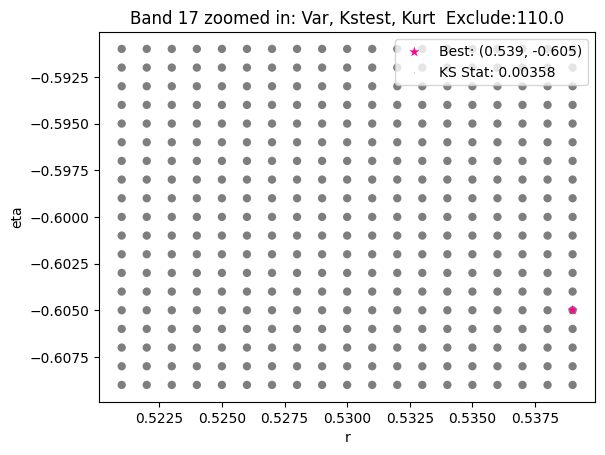

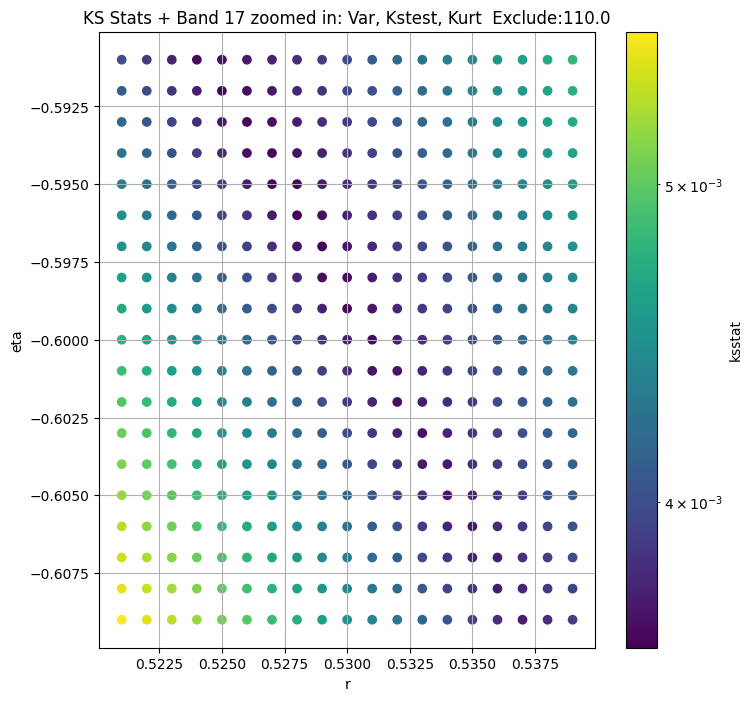

Band 20
(0.172, 1.17), 50 of 441
(0.174, 1.25), 100 of 441
(0.177, 1.12), 150 of 441
(0.179, 1.2), 200 of 441
(0.181, 1.28), 250 of 441
(0.184, 1.15), 300 of 441
(0.186, 1.23), 350 of 441
(0.189, 1.1), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 363.30it/s]


Finding Minimum after computing 441 CDFs
20 -50 0 0.00536231281262714 0.45745653 minus50


100%|██████████| 441/441 [00:01<00:00, 366.75it/s]


Finding Minimum after computing 441 CDFs
20 -40 0 0.00536231281262714 0.45745653 minus40


100%|██████████| 441/441 [00:01<00:00, 364.85it/s]


Finding Minimum after computing 441 CDFs
20 -30 0 0.00536231281262714 0.45745653 minus30


100%|██████████| 441/441 [00:01<00:00, 367.44it/s]


Finding Minimum after computing 441 CDFs
20 -20 5 0.002278941910489274 0.4230308 minus20


100%|██████████| 441/441 [00:01<00:00, 366.80it/s]


Finding Minimum after computing 441 CDFs
20 -10 15 0.0018326895076303806 0.4148403 minus10


100%|██████████| 441/441 [00:01<00:00, 364.25it/s]


Finding Minimum after computing 441 CDFs
20 0 25 0.0017195495103072833 0.4090342 0


100%|██████████| 441/441 [00:01<00:00, 367.44it/s]


Finding Minimum after computing 441 CDFs
20 10 35 0.002009810476328755 0.40421206 plus10


100%|██████████| 441/441 [00:01<00:00, 367.50it/s]


Finding Minimum after computing 441 CDFs
20 20 45 0.0022886136797162226 0.39998728 plus20


100%|██████████| 441/441 [00:01<00:00, 364.05it/s]


Finding Minimum after computing 441 CDFs
20 30 55 0.002545905919573377 0.39617643 plus30


100%|██████████| 441/441 [00:01<00:00, 367.20it/s]


Finding Minimum after computing 441 CDFs
20 40 65 0.0027860874929752644 0.39267492 plus40


100%|██████████| 441/441 [00:01<00:00, 366.96it/s]


Finding Minimum after computing 441 CDFs
20 50 75 0.0030208964719937725 0.3894162 plus50
Number of samples: 100000, Without approximation : 25140192.0
Iter 1 band 20 best parameters: (0.186, 1.11, 1.307511695915515e-07, 25.0, 0.0017195495103072833)


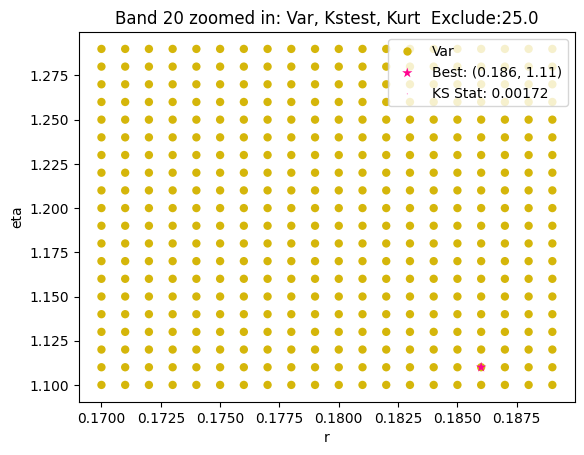

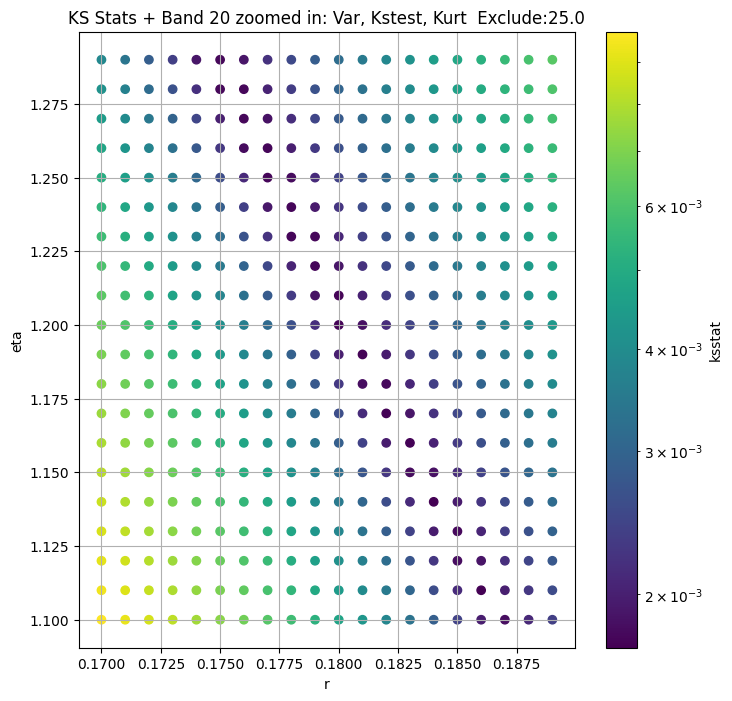

Band 23
(0.122, 3.47), 50 of 441
(0.124, 3.55), 100 of 441
(0.127, 3.42), 150 of 441
(0.129, 3.5), 200 of 441
(0.131, 3.58), 250 of 441
(0.134, 3.45), 300 of 441
(0.136, 3.53), 350 of 441
(0.139, 3.4), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 365.38it/s]


Finding Minimum after computing 441 CDFs
23 -50 0 0.0027632327629020653 0.10886136 minus50


100%|██████████| 441/441 [00:01<00:00, 368.03it/s]


Finding Minimum after computing 441 CDFs
23 -40 0 0.0027632327629020653 0.10886136 minus40


100%|██████████| 441/441 [00:01<00:00, 365.89it/s]


Finding Minimum after computing 441 CDFs
23 -30 0 0.0027632327629020653 0.10886136 minus30


100%|██████████| 441/441 [00:01<00:00, 368.33it/s]


Finding Minimum after computing 441 CDFs
23 -20 5 0.0020896204517048267 0.10541861 minus20


100%|██████████| 441/441 [00:01<00:00, 367.99it/s]


Finding Minimum after computing 441 CDFs
23 -10 15 0.0018720298411941672 0.10409678 minus10


100%|██████████| 441/441 [00:01<00:00, 366.28it/s]


Finding Minimum after computing 441 CDFs
23 0 25 0.002052889321345841 0.10307153 0


100%|██████████| 441/441 [00:01<00:00, 368.75it/s]


Finding Minimum after computing 441 CDFs
23 10 35 0.0023086584772011864 0.10218516 plus10


100%|██████████| 441/441 [00:01<00:00, 368.42it/s]


Finding Minimum after computing 441 CDFs
23 20 45 0.002541296795730341 0.10138735 plus20


100%|██████████| 441/441 [00:01<00:00, 366.34it/s]


Finding Minimum after computing 441 CDFs
23 30 55 0.0027674054991179142 0.100652486 plus30


100%|██████████| 441/441 [00:01<00:00, 367.83it/s]


Finding Minimum after computing 441 CDFs
23 40 65 0.00298619963674962 0.09996608 plus40


100%|██████████| 441/441 [00:01<00:00, 367.80it/s]


Finding Minimum after computing 441 CDFs
23 50 75 0.0031952785781491633 0.09931868 plus50
Number of samples: 100000, Without approximation : 65734528.0
Iter 1 band 23 best parameters: (0.128, 3.55, 1.869436422437192e-14, 15.0, 0.0018720298411941672)


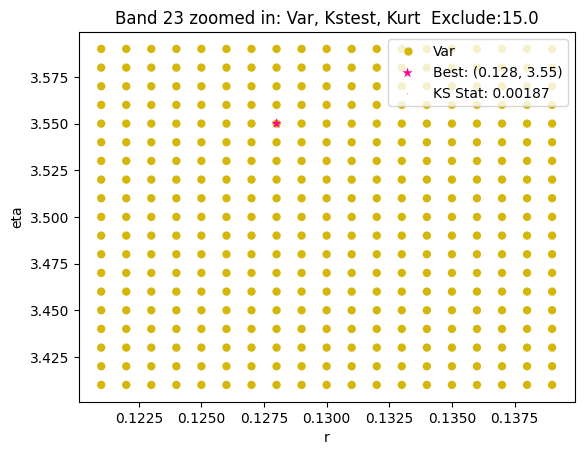

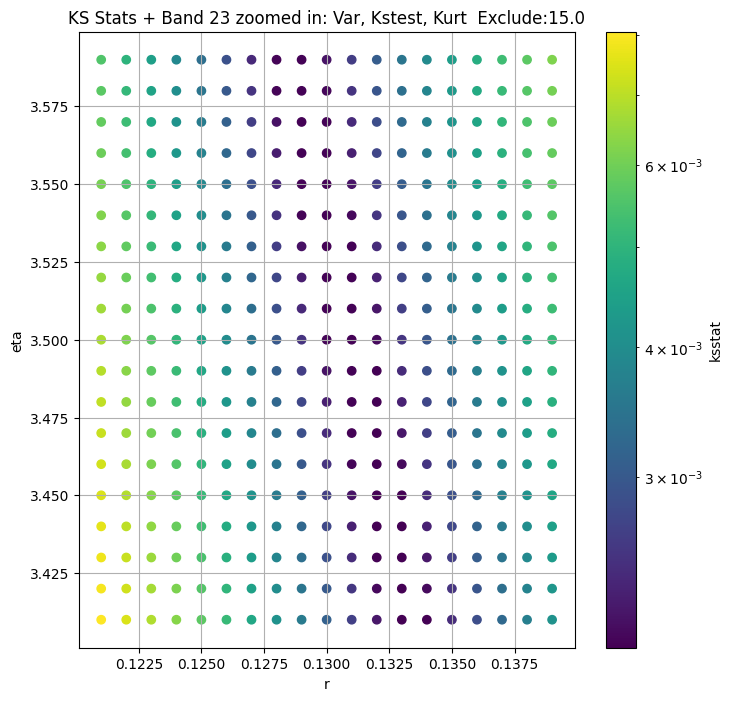

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1317.523100  1225.378300  1416.404900    5.938153    4.311650   
5      529.166600   484.306500   580.238650   10.238717    6.227644   
8      152.612470   139.443650   167.750700   10.654584    6.318540   
11      38.099050    34.947570    41.571890    9.481829    6.036282   
14      11.219242    10.258306    12.378116   11.123092    6.303248   
17       2.759864     2.472387     3.437130   38.040096    6.955560   
20       0.457457     0.391537     0.766863  212.946980    7.135597   
23       0.108861     0.098681     0.137802   38.076750    4.879170   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.405162        47614.0             0.006475       9.00        -0.91   
5      16.210070       102030.0             0.008118       2.00        -0.93   
8      24.114677       326496.0             0.007000       1.60        -0.91   
11     16.780167       904666.0             0.007038       0.90        -0.85   
14     29.718310      2727602.0             0.005593       0.72        -0.80   
17    230.069370      8298440.0             0.003723       0.53        -0.60   
20    983.588300     25140192.0             0.001751       0.18         1.20   
23    234.754040     65734528.0             0.002082       0.13         3.50   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      3.120313e+03                   150.0         1116.870117   
5      1.166934e+03                   250.0          434.717926   
8      2.904185e+02                   350.0          122.334015   
11     4.707253e+01                    75.0           35.286308   
14     8.488006e+00                   100.0           10.113163   
17     6.023926e-01                   100.0            2.406715   
20     5.584149e-08                    25.0            0.409034   
23     3.520312e-14                    25.0            0.104097   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.006220          0.006291   8.900    -0.911   
5                    0.004250          0.008020   2.070    -0.933   
8                    0.002376          0.006897   1.608    -0.915   
11                   0.001428          0.006773   0.900    -0.858   
14                   0.000822          0.005452   0.730    -0.807   
17                   0.000471          0.003577   0.539    -0.605   
20                   0.000271          0.001720   0.186     1.110   
23                   0.000168          0.001872   0.128     3.550   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     3.149148e+03                140.0      47614.0  
5     1.176776e+03                260.0      28695.0  
8     2.967092e+02                320.0      40812.0  
11    4.805005e+01                 65.0      42405.0  
14    8.841569e+00                100.0      63927.0  
17    6.417402e-01                110.0     145870.0  
20    1.307512e-07                 25.0     629211.0  
23    1.869436e-14                 15.0     513551.0

In [31]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(-50, 51, 10)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, f'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, f'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, f'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 1
            eta_granularity = 1
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), round_to_sigfigs(initial_eta, 1)]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([round_to_sigfigs(initial_r, 1), round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    eta_granularity = 10.**i
           

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']

                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                group_cdfs = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                group_cdfs_df = create_kurt_var_ksstat_df(group_cdfs)

                for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                    exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                    
                    if exclude_cutoff == 0:
                        augmented_var = np.var(group_data_map[group])
                    else:
                        augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                    group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                    ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                    
                    cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                    augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                    group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                    
                    print(group, adjust_exclude_cutoff, exclude_cutoff, min_stat, augmented_var, cutoff_label)
                    best_adjust = 0

                    if min_stat < master_df.loc[group, 'kstest_stat_best']:

                        inital_min_stat = min_stat
                        inital_best_param = initial_param
                        master_df.loc[group, 'kstest_stat_best'] = min_stat
                        initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                        master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                        master_df.loc[group, 'best_scale'] = initial_scale
                        master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                        master_df.loc[group, 'best_augmented_var'] = augmented_var
                        augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                        best_adjust = adjust_exclude_cutoff

                cutoff_label = generate_cutoff_label(best_adjust)
                ksstats = group_cdfs_df[f"ksstat_exclude_{best_adjust}"]
                
                print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
                
                cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
                master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

                best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

                group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
                group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

                group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

                group_dict = rEtaKsstats_dict[group]
                group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
                rEtaKsstats_dict[group] = group_dict

                print(f"Iter {d} {GROUP} {group} best parameters: {master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'], master_df.loc[group, 'best_scale'], master_df.loc[group, 'best_exclude_cutoff'], master_df.loc[group, f'kstest_stat_best']}")

            filtered_df = group_cdfs_df[(group_cdfs_df['r'] > master_df.loc[group, 'initial_r'] - r_granularity) & 
                            (group_cdfs_df['r'] < master_df.loc[group, 'initial_r'] + r_granularity) &
                            (group_cdfs_df['eta'] > master_df.loc[group, 'initial_eta'] - eta_granularity) &
                            (group_cdfs_df['eta'] < master_df.loc[group, 'initial_eta'] + eta_granularity)]
            
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

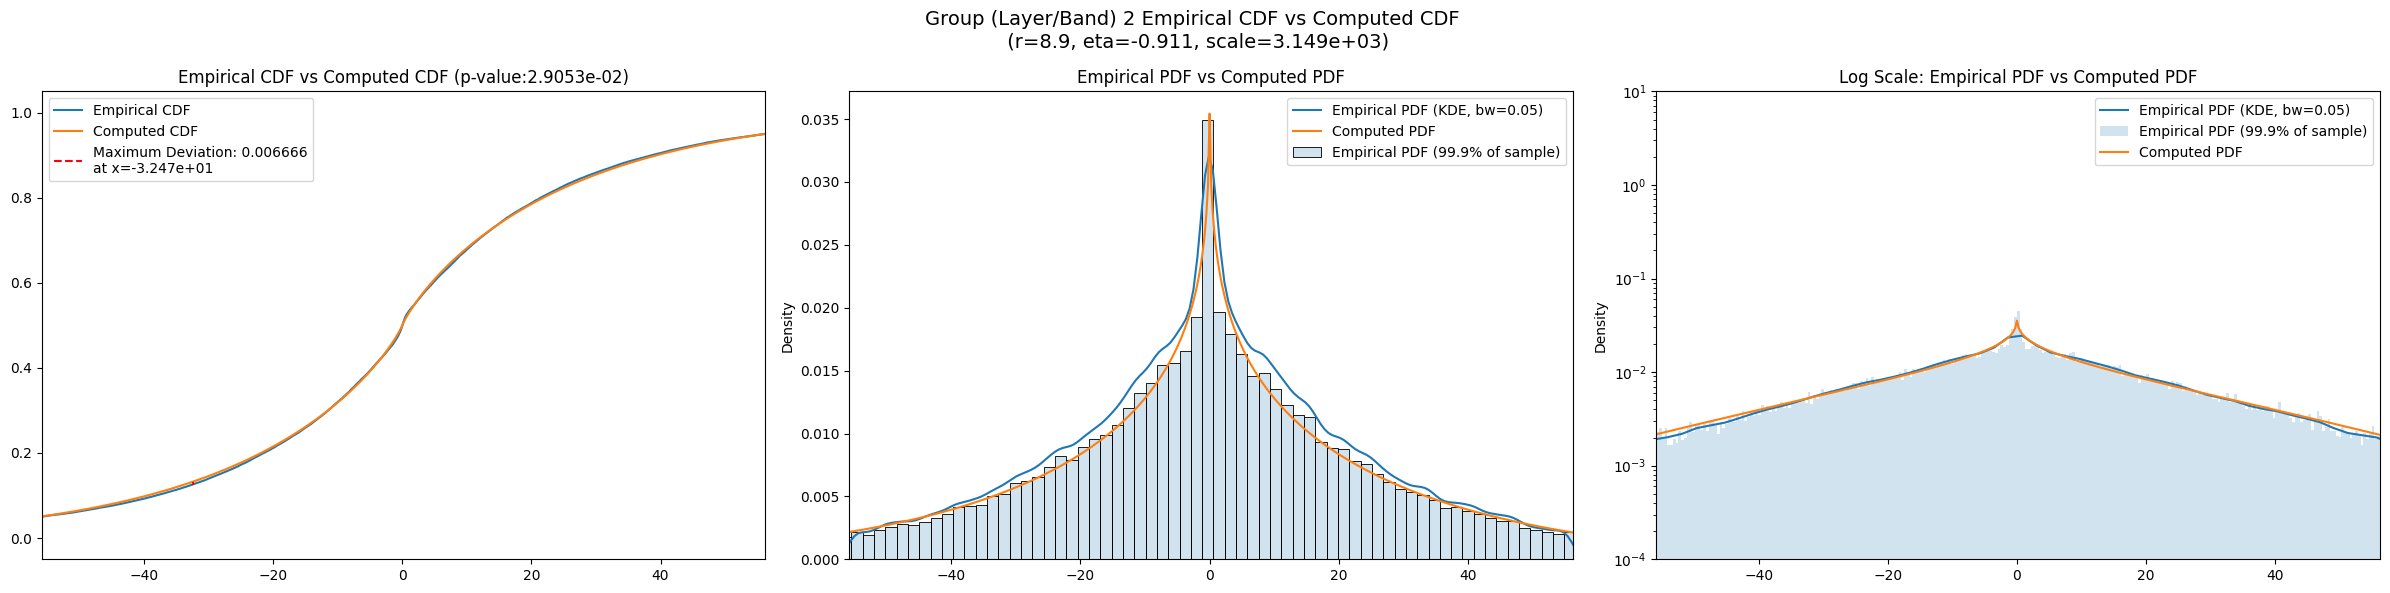

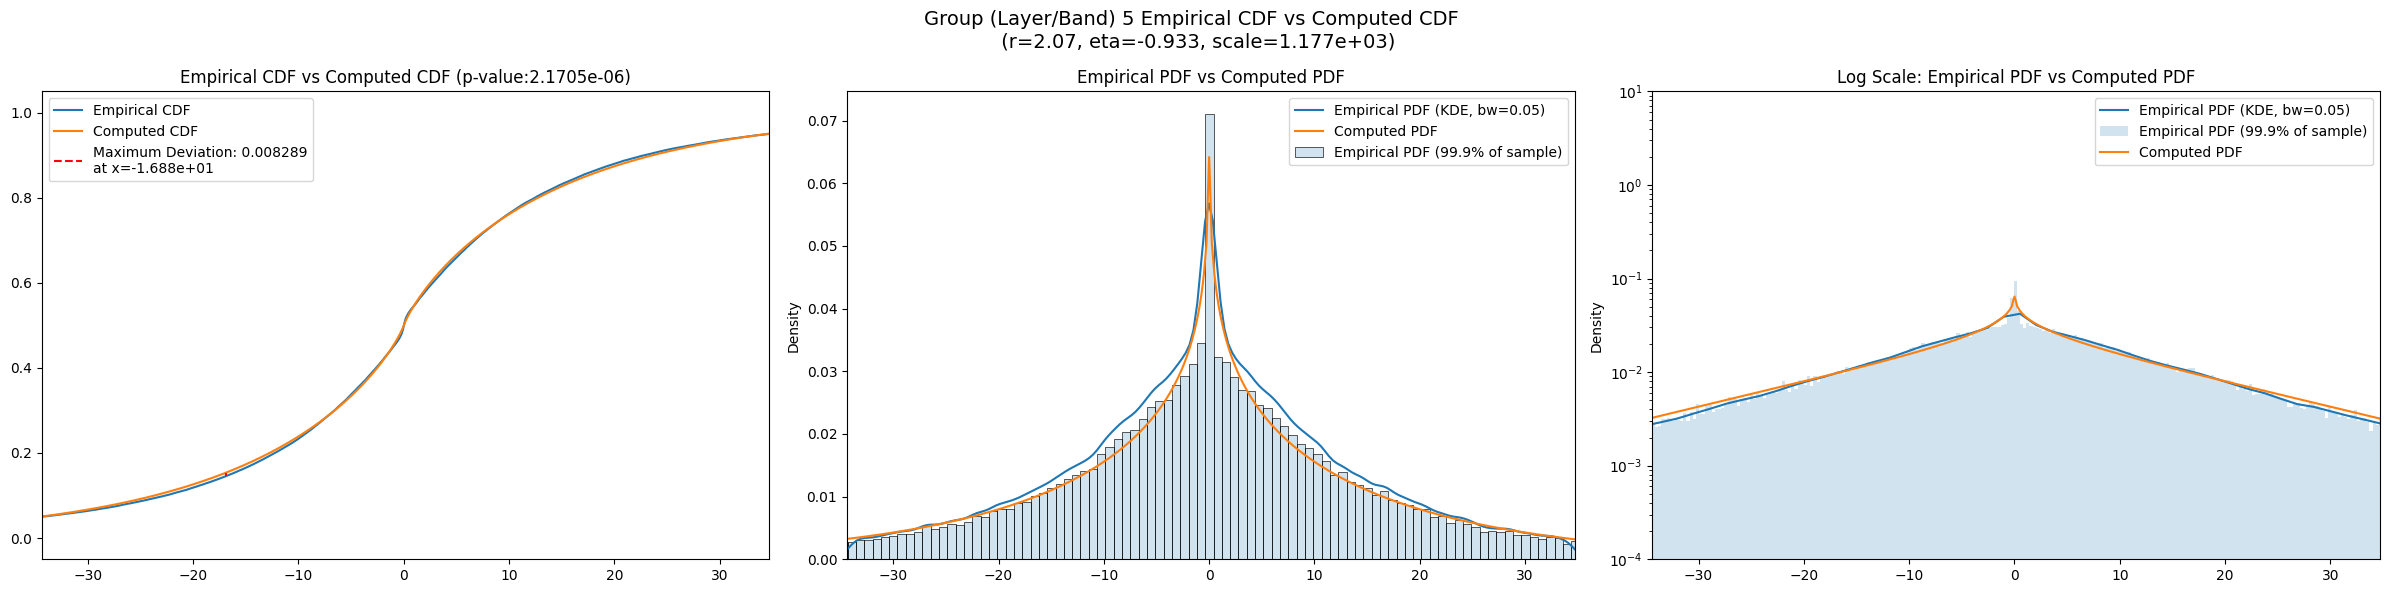

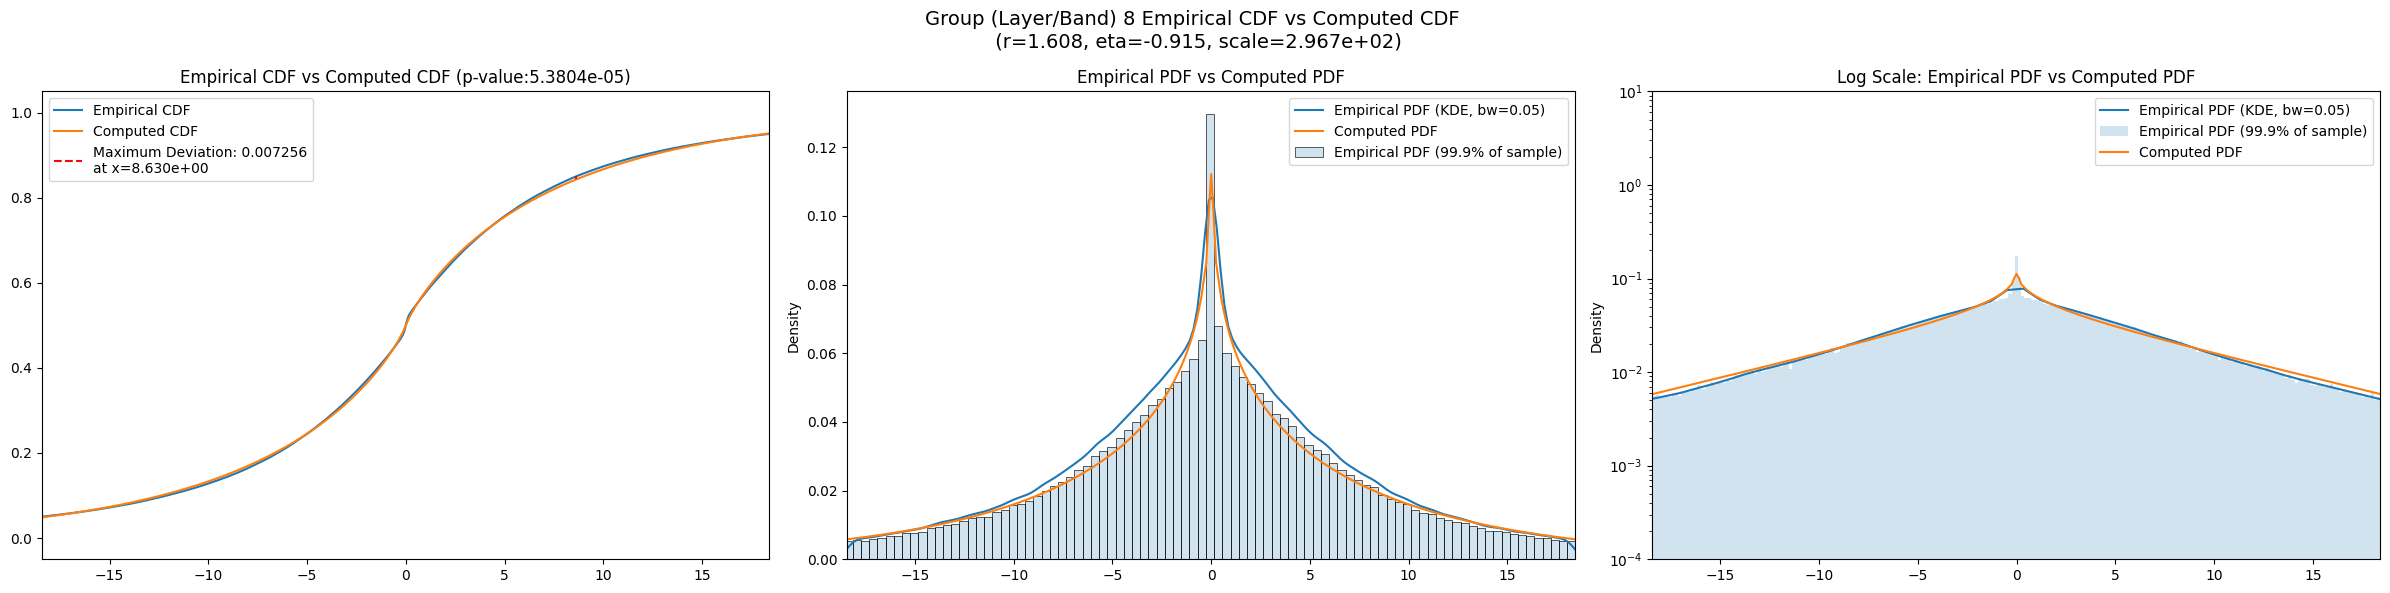

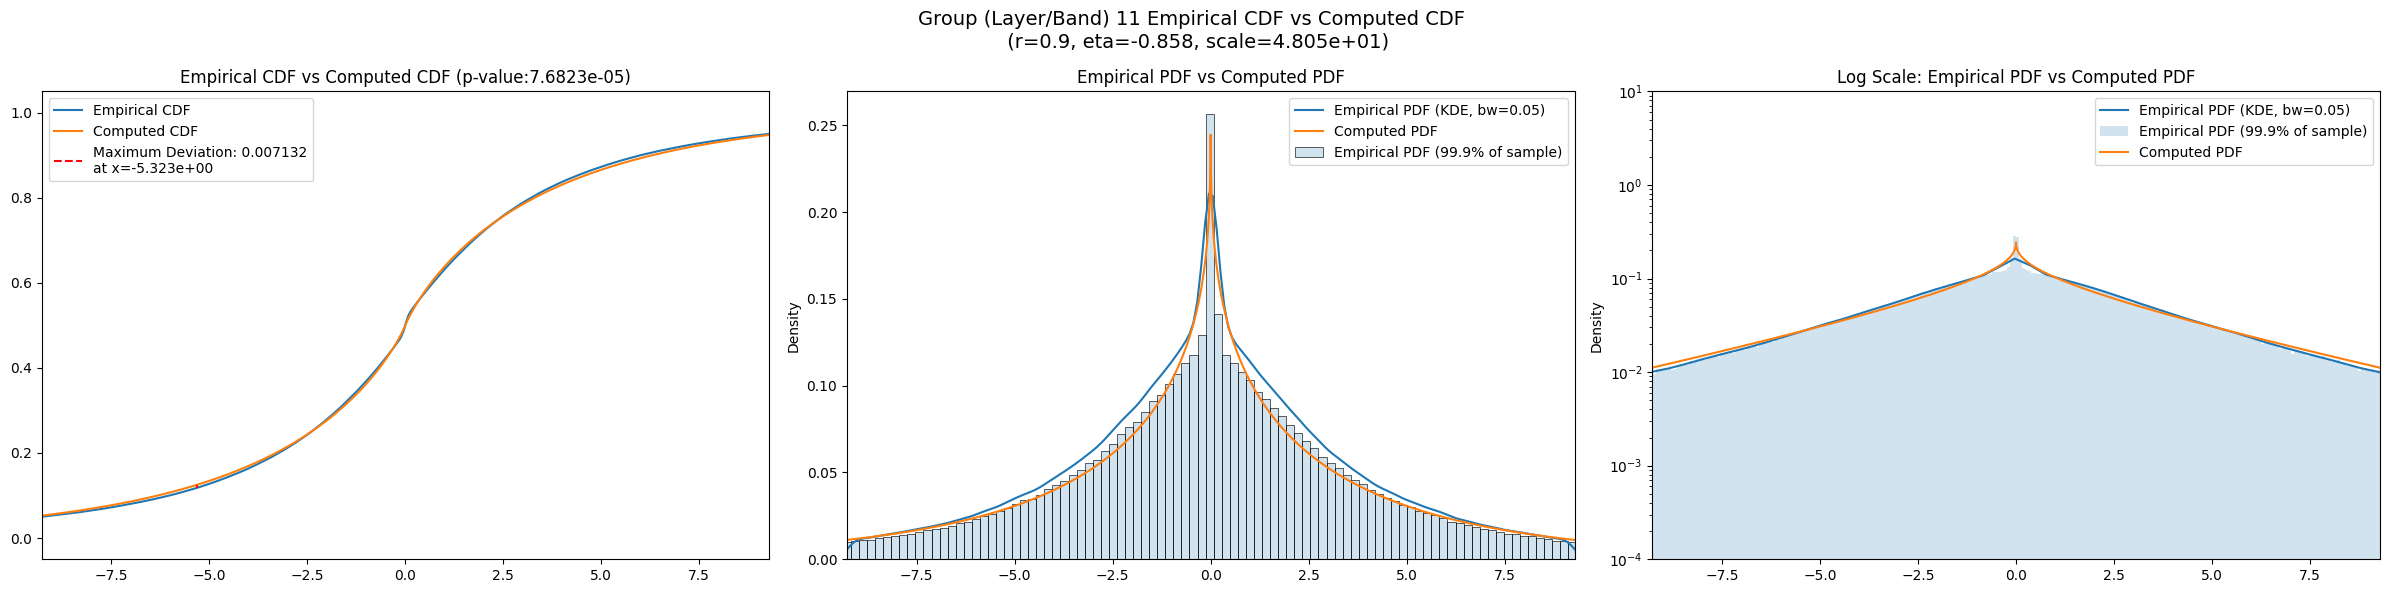

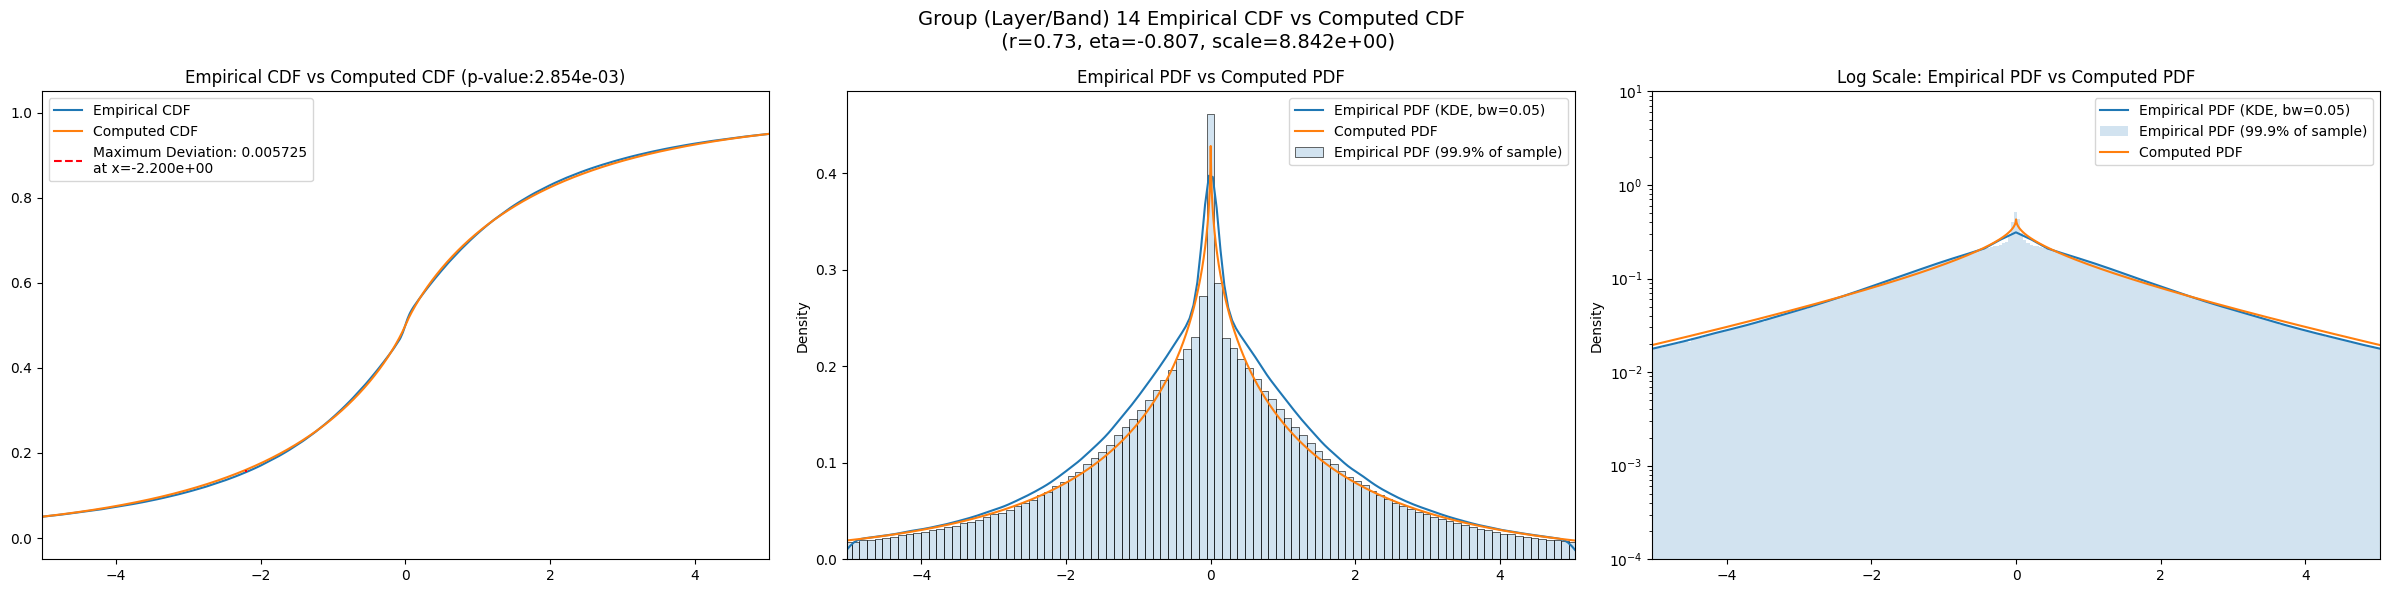

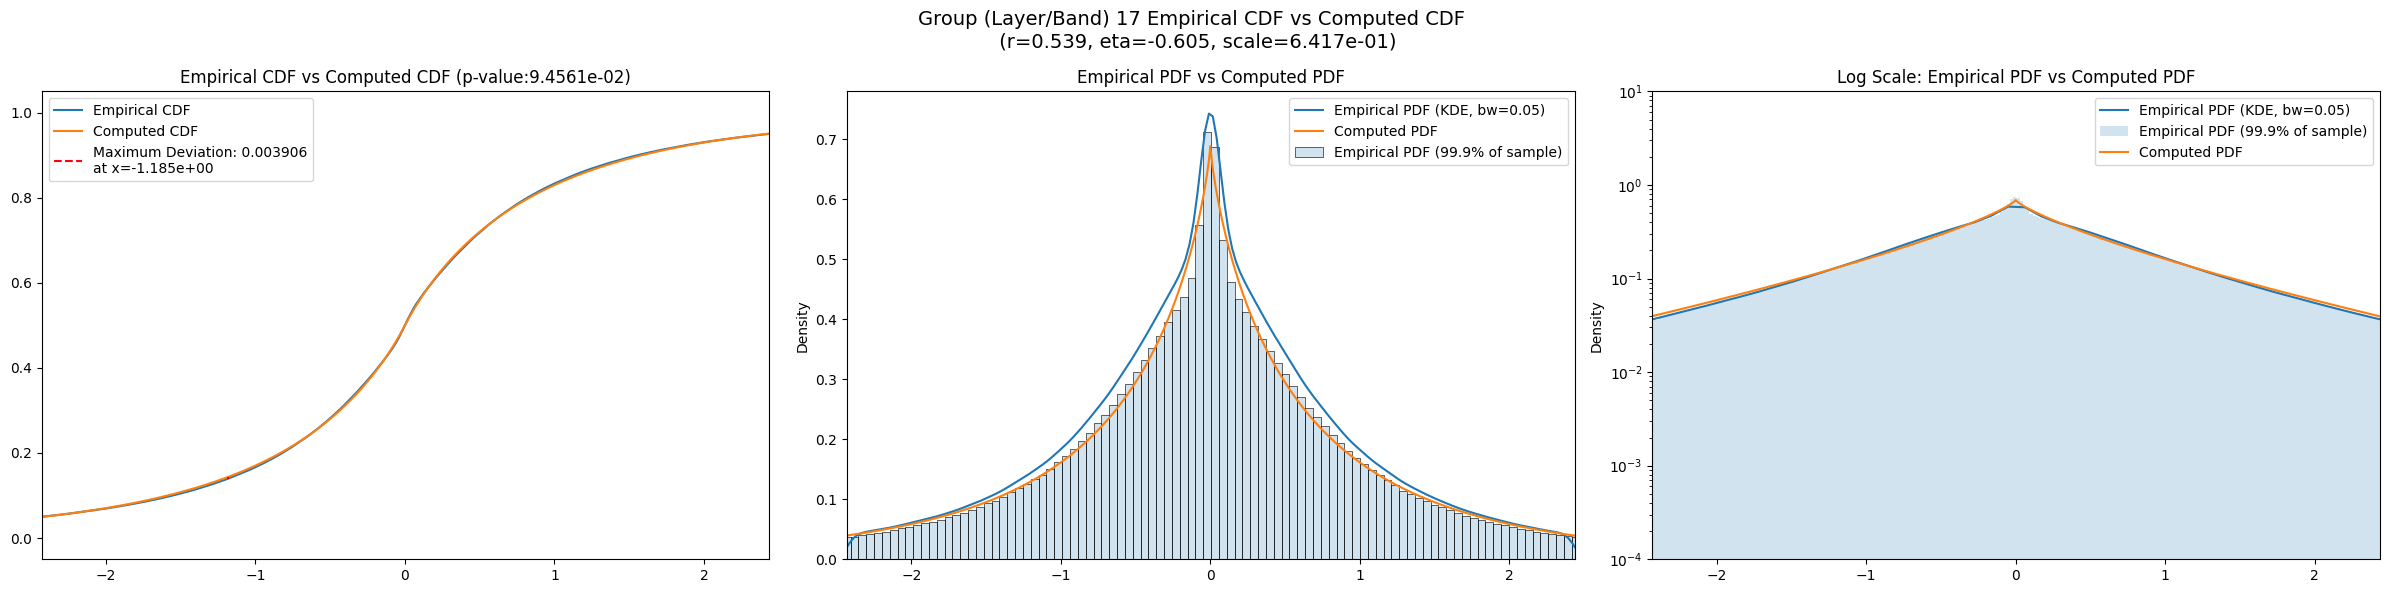

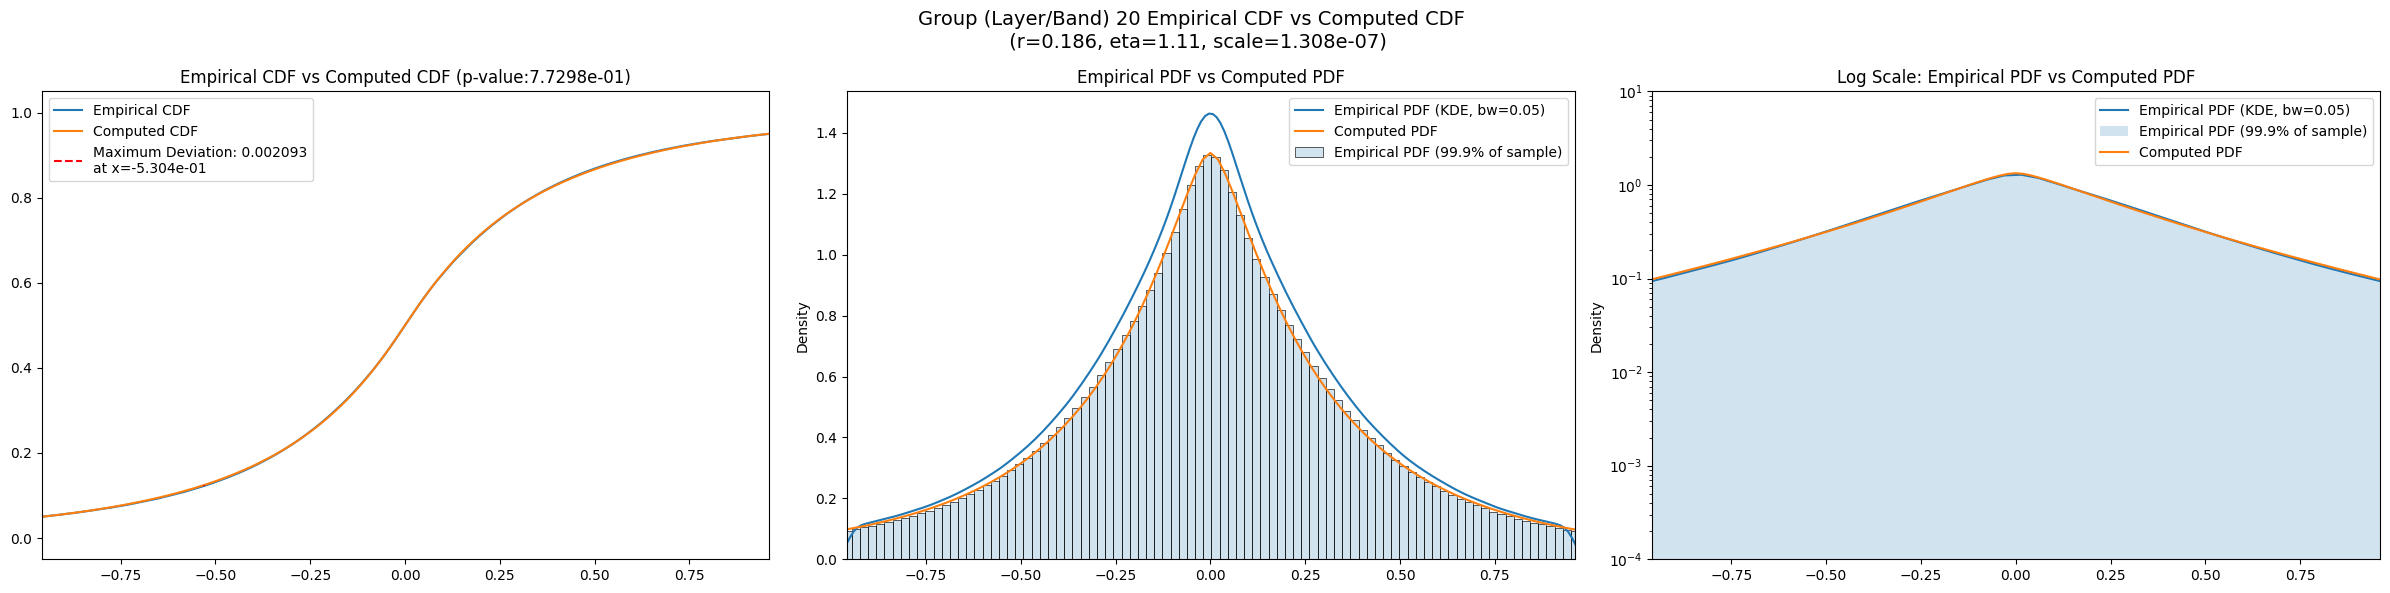

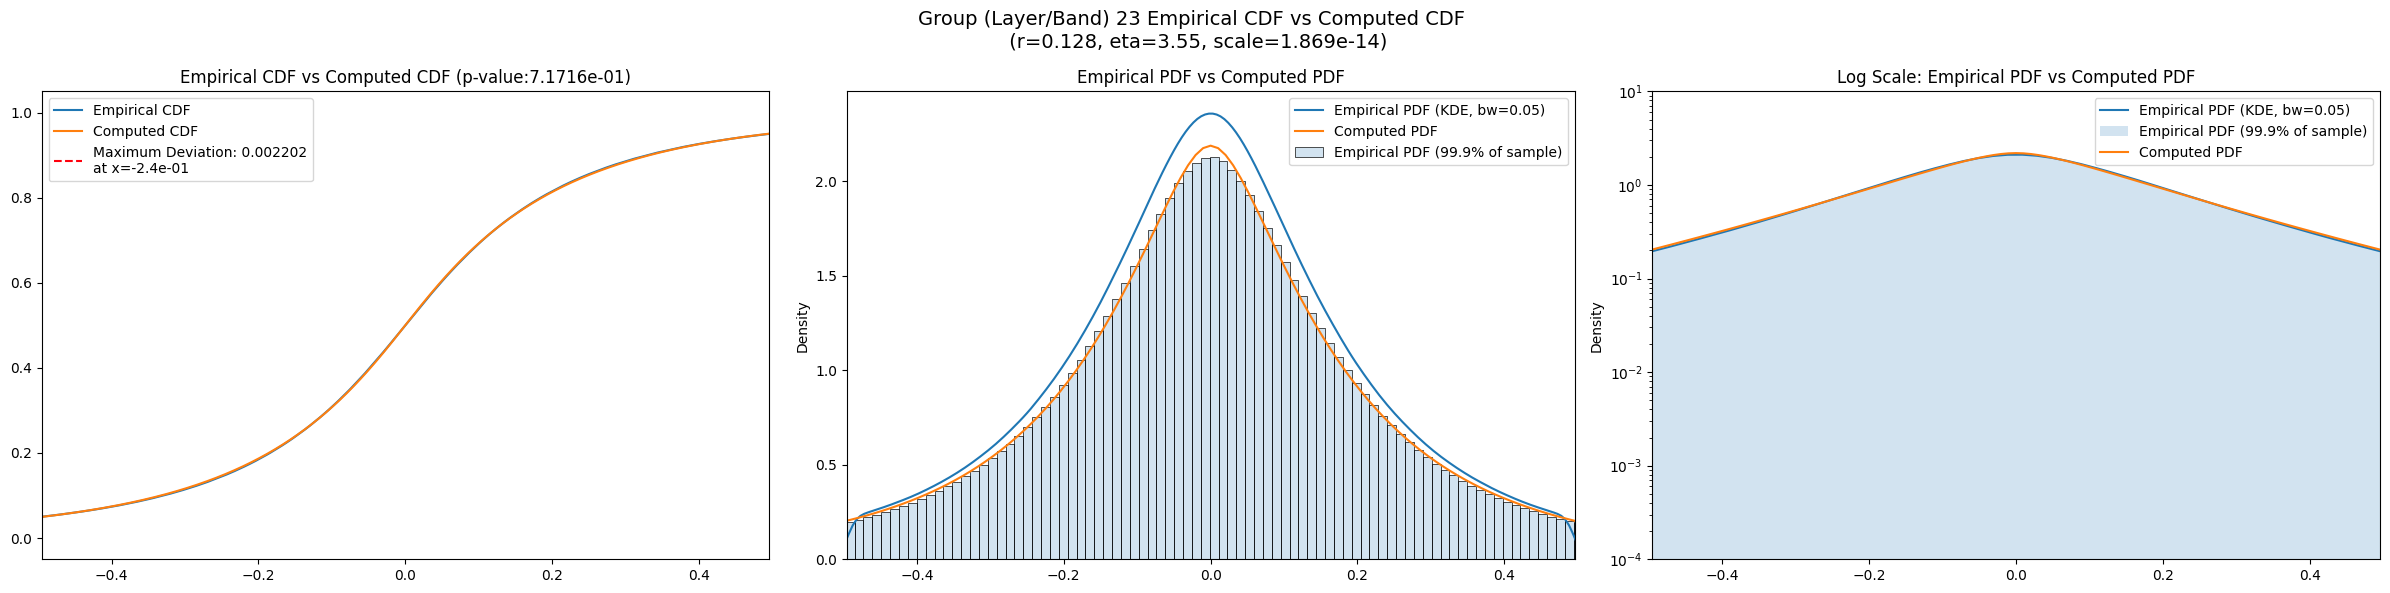

In [32]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [33]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [34]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1317.523100  1225.378300  1416.404900    5.938153    4.311650   
5      529.166600   484.306500   580.238650   10.238717    6.227644   
8      152.612470   139.443650   167.750700   10.654584    6.318540   
11      38.099050    34.947570    41.571890    9.481829    6.036282   
14      11.219242    10.258306    12.378116   11.123092    6.303248   
17       2.759864     2.472387     3.437130   38.040096    6.955560   
20       0.457457     0.391537     0.766863  212.946980    7.135597   
23       0.108861     0.098681     0.137802   38.076750    4.879170   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.405162        47614.0             0.006475       9.00        -0.91   
5      16.210070       102030.0             0.008118       2.00        -0.93   
8      24.114677       326496.0             0.007000       1.60        -0.91   
11     16.780167       904666.0             0.007038       0.90        -0.85   
14     29.718310      2727602.0             0.005593       0.72        -0.80   
17    230.069370      8298440.0             0.003723       0.53        -0.60   
20    983.588300     25140192.0             0.001751       0.18         1.20   
23    234.754040     65734528.0             0.002082       0.13         3.50   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       26.551200              0.034521          9.809910e-50   
5     ...       15.689500              0.038255         3.589890e-130   
8     ...        8.311170              0.038098          0.000000e+00   
11    ...        4.159390              0.038488          0.000000e+00   
14    ...        2.188000              0.041127          0.000000e+00   
17    ...        1.071030              0.040088          0.000000e+00   
20    ...        0.436822              0.036870          0.000000e+00   
23    ...        0.240468              0.030878          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         22.227800             0.013030         1.883500e-07  18.657100   
5         13.133500             0.015208         6.296090e-21  10.892800   
8          7.087550             0.013518         2.969630e-52   5.756650   
11         3.563010             0.013782        1.098330e-149   2.865080   
14         1.917280             0.014576         0.000000e+00   1.504440   
17         0.945254             0.013210         0.000000e+00   0.739511   
20         0.385387             0.010881         0.000000e+00   0.307329   
23         0.208616             0.006637         0.000000e+00   0.170376   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.017236   1.021520e-12          4.597109e-02  
5          0.018400   1.942210e-30          3.969086e-06  
8          0.016281   1.330270e-75          6.447010e-14  
11         0.016450  4.506960e-213          1.774851e-36  
14         0.017202   0.000000e+00          7.487412e-71  
17         0.015692   0.000000e+00          1.253945e-92  
20         0.009767   0.000000e+00          5.411100e-65  
23         0.005127   0.000000e+00         1.609901e-200  

[8 rows x 30 columns]

## Results

In [1]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [3]:
master_df.filter(regex="kstest_stat_*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.006475                 0.006220          0.006291   
5                0.008118                 0.004250          0.008020   
8                0.007000                 0.002376          0.006897   
11               0.007038                 0.001428          0.006773   
14               0.005593                 0.000822          0.005452   
17               0.003723                 0.000471          0.003577   
20               0.001751                 0.000271          0.001720   
23               0.002082                 0.000168          0.001872   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.034521             0.013030       0.017236  
5                 0.038255             0.015208       0.018400  
8                 0.038098             0.013518       0.016281  
11                0.038488             0.013782       0.016450  
14                0.041127             0.014576       0.017202  
17                0.040088             0.013210       0.015692  
20                0.036870             0.010881       0.009767  
23                0.030878             0.006637       0.005127

In [37]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))